## Introdução

Selecionar a pessoa certa para a vaga certa continua sendo um dos maiores desafios em tecnologia da informação, onde prazos curtos e projetos críticos não permitem erros de contratação. Para acelerar e aprimorar esse processo, o Datathon proposto pela **Decision** — consultoria especializada em serviços de *body-shop* e recrutamento de TI — tem como tema central a aplicação de Inteligência Artificial (IA) em recrutamento e seleção. A meta é criar soluções que unam análise de dados e modelos preditivos para elevar a eficiência do *match* entre candidatos(as) e vagas.

### Contexto do Negócio
A Decision atua conectando talentos qualificados às necessidades específicas dos seus clientes de TI. O processo de busca é conduzido por *hunters* que utilizam tanto a base interna quanto plataformas como LinkedIn, InfoJobs, Catho e grupos de WhatsApp. Entre os principais pontos de dor mapeados pela empresa estão:

- Ausência de padronização das entrevistas, provocando perda de informações valiosas.  
- Dificuldade em identificar o real engajamento dos(as) candidatos(as).  
- Pressão por preencher posições rapidamente, levando à omissão de etapas críticas e comprometendo a qualidade da seleção.

### Desafio do Datathon
Como engenheiro(a) de Machine Learning, seu objetivo é propor uma IA que mitigue essas dores, oferecendo recursos como:

- **Agente virtual de entrevistas** capaz de replicar o *know-how* dos *hunters*.  
- **Modelos de matching** que aprendam padrões de sucesso de contratações passadas para recomendar novos(as) candidatos(as).  
- **Ferramentas de priorização de entrevistas**, mensurando engajamento e *fit* cultural em tempo real.

### Estrutura dos Dados
Para respaldar essas soluções, foram disponibilizados três conjuntos de dados anonimizados em formato JSON:

| Arquivo          | Conteúdo principal                                                                                                   |
|------------------|-----------------------------------------------------------------------------------------------------------------------|
| **Jobs.json**    | Informações das vagas (cliente, senioridade, requisitos técnicos, benefícios, indicação se é vaga SAP etc.).          |
| **Prospects.json** | Lista de candidatos(as) prospectados(as) por vaga, com código, comentários e status no funil.                        |
| **Applicants.json** | Perfil completo dos(as) candidatos(as): dados pessoais, formação, experiência, níveis de idioma, skills e currículo. |

Relação entre arquivos: o **código da vaga** conecta *Jobs* a suas *Prospects* e, dentro destas, cada prospect contém o **código do(a) candidato(a)** presente em *Applicants*.

### Objetivos da Análise Exploratória (EDA)
Antes de construir modelos, a EDA buscará:

1. Entender o volume, a qualidade e a distribuição das informações disponíveis.  
2. Identificar variáveis críticas para prever sucesso de contratação (ex.: senioridade, habilidades técnicas, *fit* cultural).  
3. Explorar padrões de engajamento e gargalos do funil (taxas de resposta, desistências, tempo até contratação).  
4. Detectar lacunas nos dados que exijam tratamento ou enriquecimento externo.

A partir desses insights, definiremos métricas-alvo, estratégias de *feature engineering* e arquiteturas de modelo adequadas, pavimentando o caminho para prototipar e colocar em produção uma solução de IA que potencialize o trabalho dos(as) *hunters* e melhore a experiência de candidatos(as) e clientes.


In [1]:
pip install polars

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 22.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import json
from pathlib import Path
import polars as pl


# ------------------------------------------------------------------------------
# 1. Utilidades de caminho
# ------------------------------------------------------------------------------

def find_data_root(start: Path = Path.cwd()) -> Path:
    """
    Sobe na árvore de diretórios até encontrar a pasta data/raw.
    Lança FileNotFoundError se não existir.
    """
    for parent in [start, *start.parents]:
        candidate = parent / "data" / "raw"
        if candidate.is_dir():
            return candidate
    raise FileNotFoundError("Diretório data/raw não encontrado.")


DATA_ROOT = find_data_root()                     # ../data/raw  ou ./data/raw


# ------------------------------------------------------------------------------
# 2. Função de leitura → Polars DataFrame
# ------------------------------------------------------------------------------

def load_json_to_df(file_path: Path, id_field: str) -> pl.DataFrame:
    """
    Lê um JSON. Se o topo é um dict cujas chaves são IDs,
    devolve um DataFrame “achatado” com a chave em `id_field`.
    """
    with file_path.open(encoding="utf-8") as f:
        data = json.load(f)

    if isinstance(data, dict):
        data = [{id_field: k, **v} for k, v in data.items()]

    return pl.from_dicts(data)


# ------------------------------------------------------------------------------
# 3. Conversão de schema (Polars) → dict aninhado
# ------------------------------------------------------------------------------

def dtype_to_nested(d):
    """Converte um pl.DataType em representação Python aninhada."""
    # Struct → percorre cada Field
    if isinstance(d, pl.datatypes.Struct):        # ← via isinstance
        return {fld.name: dtype_to_nested(fld.dtype) for fld in d.fields}

    # List → descreve o tipo interno
    if isinstance(d, pl.datatypes.List):          # ← via isinstance
        return {"list_of": dtype_to_nested(d.inner)}

    # Tipos escalares
    return str(d)

def schema_to_dict(df: pl.DataFrame) -> dict:
    """Schema completo do DataFrame em dicionário aninhado."""
    return {col: dtype_to_nested(dtype) for col, dtype in df.schema.items()}


# ------------------------------------------------------------------------------
# 4. Caminhos dos arquivos
# ------------------------------------------------------------------------------

jobs_fp       = DATA_ROOT / "jobs"       / "jobs.json"
prospects_fp  = DATA_ROOT / "prospects"  / "prospects.json"
applicants_fp = DATA_ROOT / "applicants" / "applicants.json"


# ------------------------------------------------------------------------------
# 5. Leitura dos DataFrames
# ------------------------------------------------------------------------------

jobs_df       = load_json_to_df(jobs_fp,       id_field="codigo_vaga")
prospects_df  = load_json_to_df(prospects_fp,  id_field="codigo_vaga")
applicants_df = load_json_to_df(applicants_fp, id_field="codigo_candidato")


# ------------------------------------------------------------------------------
# 6. Display – primeiras linhas + schema expandido
# ------------------------------------------------------------------------------

def show(df: pl.DataFrame, name: str):
    print(f"\n===== {name} =====\n")
    print(df.head())
    print(f"\n=== {name} schema (expandido) ===")
    print(json.dumps(schema_to_dict(df), indent=4, ensure_ascii=False))


show(jobs_df,       "Jobs.json")
show(prospects_df,  "Prospects.json")
show(applicants_df, "Applicants.json")



===== Jobs.json =====

shape: (5, 4)
┌─────────────┬─────────────────────────────────┬──────────────────┬──────────────────────┐
│ codigo_vaga ┆ informacoes_basicas             ┆ perfil_vaga      ┆ beneficios           │
│ ---         ┆ ---                             ┆ ---              ┆ ---                  │
│ str         ┆ struct[19]                      ┆ struct[21]       ┆ struct[3]            │
╞═════════════╪═════════════════════════════════╪══════════════════╪══════════════════════╡
│ 5185        ┆ {"04-05-2021","00-00-0000","Op… ┆ {"Brasil","São   ┆ {"-","R$",""}        │
│             ┆                                 ┆ Paulo","São Pau… ┆                      │
│ 5184        ┆ {"04-05-2021","00-00-0000","Co… ┆ {"Brasil","São   ┆ {"-","R$",""}        │
│             ┆                                 ┆ Paulo","São Pau… ┆                      │
│ 5183        ┆ {"04-05-2021","00-00-0000","AN… ┆ {"Brasil","São   ┆ {"-","R$",""}        │
│             ┆                           

## Análise do Schema Expandido dos Arquivos JSON

### 1. Visão Geral dos Arquivos

Os três arquivos seguem um padrão em que **a chave primária é textual** e o corpo contém objetos (`Structs`) ou listas aninhadas:

| Arquivo            | Chave primária   | Estrutura dominante |
|--------------------|------------------|---------------------|
| `Jobs.json`        | `codigo_vaga`    | 3 structs grandes   |
| `Prospects.json`   | `codigo_vaga`    | lista de prospects  |
| `Applicants.json`  | `codigo_candidato` | 4 structs + textos |

> Observação: no `Prospects.json`, o campo `codigo` dentro da lista **prospects** corresponde ao `codigo_candidato` do `Applicants.json`, ligação essencial para juntar as duas bases[1].

---

### 2. Detalhes por Arquivo

#### 2.1 Jobs.json
- Estrutura em três blocos: **informacoes_basicas**, **perfil_vaga** e **beneficios**.  
- Todos os 46 + campos são *strings*; será preciso tipar datas, valores numéricos e categorias antes de modelar.  
- A quantidade de atributos sugere que técnicas de redução de dimensionalidade ou seleção de variáveis poderão ser úteis.[1]

#### 2.2 Prospects.json
- Contém metadados da vaga e uma **lista de prospects** (candidatos).  
- Cada prospect guarda nome, `codigo`, situação e comentários.  
- Como é lista de structs, será necessário *explodir* para obter uma linha por candidato–vaga.  
- As datas de candidatura e atualização podem indicar engajamento ou velocidade do funil.[1]

#### 2.3 Applicants.json
- Traz dados pessoais, profissionais, formação e currículos em PT/EN.  
- Campos sensíveis já estão anonimizados; ainda assim, há múltiplas colunas textuais extensas (`cv_pt`, `cv_en`) que podem ser transformadas em embeddings.  
- Vários atributos de nível profissional, idiomas e certificações são bons candidatos a variáveis categóricas para o modelo de *matching*.[1]

---

### 3. Próximos Passos Analíticos

1. **Explodir os campos aninhados** para criar uma *one big table* por arquivo, facilitando EDA quantitativa e qualitativa.  
2. Tratar tipos (datas, numéricos) e padronizar categorias.  
3. Unir `Prospects` a `Applicants` pelo par (`codigo_vaga`, `codigo_candidato`).  
4. Construir métricas de sucesso – tempo até contratação, taxa de conversão, aderência de skills – para servir de alvo aos modelos de IA.

A seguir, apresento o código Polars para realizar a etapa de *explode*.


In [2]:
import re

# ------------------------------------------------------------------
# 1. Função para gerar prefixos a partir dos nomes das colunas
# ------------------------------------------------------------------
def get_initials(name: str) -> str:
    """
    Extrai iniciais de um nome, tratando snake_case, camelCase e kebab-case.
    Ex: 'informacoes_basicas' -> 'ib', 'perfilVaga' -> 'pv'.
    """
    # Insere espaço antes de letra maiúscula (camelCase) e troca _/- por espaço
    s1 = re.sub(r'([A-Z])', r' \1', name).strip()
    s2 = re.sub(r'[-_]', ' ', s1)
    # Pega a primeira letra de cada palavra resultante e junta em minúsculas
    return "".join(word[0] for word in s2.split()).lower()

# ------------------------------------------------------------------
# 2. Função principal para explodir e achatar os DataFrames
# ------------------------------------------------------------------
def default_explode(
    jobs_df: pl.DataFrame,
    prospects_df: pl.DataFrame,
    applicants_df: pl.DataFrame
) -> tuple[pl.DataFrame, pl.DataFrame, pl.DataFrame]:
    """
    Recebe os 3 DataFrames brutos e retorna suas versões achatadas ('flat'),
    com colunas prefixadas pelas iniciais das structs de origem.
    """
    df_flat = jobs_df.clone()
    # Itera sobre as colunas para encontrar e achatar Structs
    for col_name in jobs_df.columns:
        dtype = jobs_df.schema[col_name]
        if isinstance(dtype, pl.datatypes.Struct):
            prefix = get_initials(col_name)
            # Pega os nomes dos campos dentro do struct
            field_names = [f.name for f in dtype.fields]
            new_names = [f"{prefix}_{field}" for field in field_names]
            # Renomeia os campos e depois faz o unnest
            df_flat = df_flat.with_columns(
                pl.col(col_name).struct.rename_fields(new_names)
            ).unnest(col_name)
    jobs_flat = df_flat

    # Para prospects, primeiro explode a lista, depois achata o struct
    prospects_flat = (
        prospects_df.clone()
        .explode("prospects") # Transforma a lista de structs em múltiplas linhas
        .unnest("prospects")  # Achata o struct resultante
        .rename({"codigo": "codigo_candidato"}) # Renomeia a chave para join futuro
    )
    # Adiciona prefixo 'pr_' a todas as colunas que vieram do struct 'prospects'
    pr_prefix_cols = {c: f"pr_{c}" for c in prospects_flat.columns if c not in prospects_df.columns}
    prospects_flat = prospects_flat.rename(pr_prefix_cols)

    df_flat = applicants_df.clone()
    # Repete a mesma lógica do jobs_df para o applicants_df
    for col_name in applicants_df.columns:
        dtype = applicants_df.schema[col_name]
        if isinstance(dtype, pl.datatypes.Struct):
            prefix = get_initials(col_name)
            field_names = [f.name for f in dtype.fields]
            new_names = [f"{prefix}_{field}" for field in field_names]
            df_flat = df_flat.with_columns(
                pl.col(col_name).struct.rename_fields(new_names)
            ).unnest(col_name)
    applicants_flat = df_flat

    return jobs_flat, prospects_flat, applicants_flat

# Chamada da função principal
jobs_flat, prospects_flat, applicants_flat = default_explode(jobs_df, prospects_df, applicants_df)

# Exibição dos resultados
print("--- Jobs Flat (Achatado) ---")
print(jobs_flat.head())
print("\n--- Prospects Flat (Achatado) ---")
print(prospects_flat.head())
print("\n--- Applicants Flat (Achatado) ---")
print(applicants_flat.head())


--- Jobs Flat (Achatado) ---
shape: (5, 44)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ codigo_va ┆ ib_data_r ┆ ib_limite ┆ ib_titulo ┆ … ┆ pv_habili ┆ b_valor_v ┆ b_valor_c ┆ b_valor_ │
│ ga        ┆ equicisao ┆ _esperado ┆ _vaga     ┆   ┆ dades_com ┆ enda      ┆ ompra_1   ┆ compra_2 │
│ ---       ┆ ---       ┆ _para_con ┆ ---       ┆   ┆ portament ┆ ---       ┆ ---       ┆ ---      │
│ str       ┆ str       ┆ tra…      ┆ str       ┆   ┆ ais…      ┆ str       ┆ str       ┆ str      │
│           ┆           ┆ ---       ┆           ┆   ┆ ---       ┆           ┆           ┆          │
│           ┆           ┆ str       ┆           ┆   ┆ str       ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 5185      ┆ 04-05-202 ┆ 00-00-000 ┆ Operation ┆ … ┆ null      ┆ -         ┆ R$        ┆          │
│           ┆ 1         ┆ 0         ┆ Lead -   

# Avaliação Qualitativa dos Dados: Plano de Análise

O objetivo desta etapa é ir além das contagens e tipos de dados, buscando entender a "personalidade" dos dados antes de qualquer modelagem. Isso nos permitirá formular hipóteses sobre quais colunas são mais promissoras, quais precisam de limpeza e como podemos extrair mais valor delas.

Nossa análise se baseará nos seguintes pilares:

1.  **Identificação de Padrões (Seleção vs. Input Livre)**
    *   **O que é?** Diferenciar colunas que provavelmente vêm de um menu de seleção (ex: "CLT", "PJ") daquelas que são campos de texto livre (ex: "objetivo_vaga").
    *   **Como?** Analisando o número de valores únicos (`n_unique`). Uma contagem baixa de valores únicos para um grande número de registros sugere um campo categórico (seleção). Uma contagem alta sugere texto livre.

2.  **Disposição dos Nulos**
    *   **O que é?** Mapear a quantidade e a porcentagem de valores nulos por coluna.
    *   **Como?** Calculando `null_count` e `null_percent`. Isso revela a completude dos dados e nos ajuda a decidir entre remover, preencher ou usar colunas com dados faltantes.

3.  **Análise de Campos Textuais (String)**
    *   **O que é?** Entender a distribuição do tamanho dos textos em cada coluna.
    *   **Como?** Calculando o comprimento mínimo, máximo e médio dos valores (`min_len`, `max_len`, `avg_len`). Isso ajuda a identificar campos que são apenas códigos, outros que são descrições longas, e a detectar outliers.

4.  **Identificação de Campos para *Split***
    *   **O que é?** Encontrar colunas que armazenam múltiplas informações em uma única string, geralmente separadas por vírgulas, ponto e vírgula ou barras (ex: `pv_competencia_tecnicas_e_comportamentais`).
    *   **Como?** Inspecionando colunas com alta cardinalidade e comprimentos de texto variáveis. Uma função específica pode ser criada para contar a ocorrência de delimitadores comuns.

## Estratégia de Implementação

Para consolidar essa análise, criaremos a função `qualitative_analysis_summary` que recebe um DataFrame e retorna um novo DataFrame de metadados, onde cada linha descreve uma coluna do DataFrame original. Isso facilita a ordenação e a filtragem para encontrar os insights mais relevantes e guiar as próximas etapas de pré-processamento.


In [3]:
def qualitative_analysis_summary(df: pl.DataFrame) -> pl.DataFrame:
    """
    Gera um resumo qualitativo para cada coluna de um DataFrame Polars.

    A análise inclui contagem de nulos, valores únicos, e estatísticas
    de comprimento para colunas de texto.

    Args:
        df: O DataFrame a ser analisado.

    Returns:
        Um novo DataFrame com os metadados de cada coluna.
    """
    metadata = []
    for col_name in df.columns:
        col_stats = {'column': col_name, 'dtype': df[col_name].dtype}
        
        # Análise de Nulos
        null_count = df[col_name].is_null().sum()
        col_stats['null_count'] = null_count
        col_stats['null_percent'] = (null_count / len(df)) * 100 if len(df) > 0 else 0
        
        # Análise de Cardinalidade (Valores Únicos)
        col_stats['n_unique'] = df[col_name].n_unique()
        
        # Análise de Comprimento para colunas de Texto (String)
        if isinstance(df[col_name].dtype, pl.String):
            # Ignora nulos para cálculo de comprimento
            lengths = df.get_column(col_name).drop_nulls().str.len_chars()
            if len(lengths) > 0:
                col_stats['min_len'] = lengths.min()
                col_stats['max_len'] = lengths.max()
                col_stats['avg_len'] = lengths.mean()
            else: # Coluna de texto é inteiramente nula
                col_stats['min_len'] = 0
                col_stats['max_len'] = 0
                col_stats['avg_len'] = 0.0
        else: # Para colunas não-texto
            col_stats['min_len'] = None
            col_stats['max_len'] = None
            col_stats['avg_len'] = None
            
        metadata.append(col_stats)
        
    return pl.DataFrame(metadata).sort("null_percent", descending=True)


---

### Jobs vision analysis

In [4]:
pl.Config.set_tbl_rows(-1)  # Exibe todas as linhas
pl.Config.set_tbl_cols(-1)  # Exibe todas as colunas
pl.Config.set_fmt_str_lengths(200)
from IPython.display import display
# ------------------------------------------------------------------------------
# -1. Gerar o resumo qualitativo
# ------------------------------------------------------------------------------
jobs_summary = qualitative_analysis_summary(jobs_flat)

# ------------------------------------------------------------------------------
# 0. Exibir o resumo, mostrando as colunas mais problemáticas (com mais nulos) primeiro
# ------------------------------------------------------------------------------
print("--- Resumo Qualitativo do DataFrame 'jobs_flat' ---")
display(jobs_summary)

# ------------------------------------------------------------------------------
# 1. Colunas com maior percentual de nulos (piores em preenchimento)
# ------------------------------------------------------------------------------
print("\n[INFO] Top 5 colunas com mais valores nulos:")
display(jobs_summary.select("column", "null_percent").head(5))

# ------------------------------------------------------------------------------
# 2. Identificando campos de SELEÇÃO (baixa cardinalidade, poucos valores únicos)
# ------------------------------------------------------------------------------
print("\n[INFO] Possíveis campos de seleção (categóricos):")
display(
    jobs_summary
    .filter(pl.col("n_unique") <= 100) # Ex: menos de 100 opções
    .select("column", "n_unique")
    .sort("n_unique")
)

# ------------------------------------------------------------------------------
# 3. Identificando campos de TEXTO LIVRE (alta cardinalidade e grande variação de tamanho)
# ------------------------------------------------------------------------------
print("\n[INFO] Possíveis campos de texto livre (descritivos):")
display(
    jobs_summary
    .filter(pl.col("avg_len") > 40) # Média de caracteres alta
    .select("column", "avg_len", "max_len", "n_unique")
    .sort("avg_len", descending=True)
)

--- Resumo Qualitativo do DataFrame 'jobs_flat' ---


column,dtype,null_count,null_percent,n_unique,min_len,max_len,avg_len
str,object,i64,f64,i64,i64,i64,f64
"""pv_habilidades_comportamentais_necessarias""",String,11396,80.931752,1840,0,1759,79.07784
"""ib_data_inicial""",String,9625,68.35452,849,10,10,10.0
"""ib_data_final""",String,9625,68.35452,1245,10,10,10.0
"""ib_telefone""",String,4762,33.818621,5,0,15,0.003756
"""ib_nome""",String,4456,31.64548,82,0,34,0.168208
"""pv_equipamentos_necessarios""",String,2685,19.068248,8,0,38,4.586522
"""ib_superior_imediato""",String,42,0.298274,2,18,18,18.0
"""codigo_vaga""",String,0,0.0,14081,1,5,4.21774
"""ib_data_requicisao""",String,0,0.0,1543,10,10,10.0



[INFO] Top 5 colunas com mais valores nulos:


column,null_percent
str,f64
"""pv_habilidades_comportamentais_necessarias""",80.931752
"""ib_data_inicial""",68.35452
"""ib_data_final""",68.35452
"""ib_telefone""",33.818621
"""ib_nome""",31.64548



[INFO] Possíveis campos de seleção (categóricos):


column,n_unique
str,i64
"""pv_pais""",1
"""ib_superior_imediato""",2
"""ib_vaga_sap""",2
"""ib_empresa_divisao""",2
"""pv_local_trabalho""",2
"""ib_prazo_contratacao""",3
"""ib_origem_vaga""",3
"""pv_vaga_especifica_para_pcd""",3
"""pv_viagens_requeridas""",3



[INFO] Possíveis campos de texto livre (descritivos):


column,avg_len,max_len,n_unique
str,f64,i64,i64
"""pv_principais_atividades""",377.826788,6114,11710
"""pv_competencia_tecnicas_e_comportamentais""",353.488176,5835,11552
"""pv_demais_observacoes""",96.533343,3898,6729
"""pv_habilidades_comportamentais_necessarias""",79.07784,1759,1840


### Avaliação Qualitativa de `jobs_flat` e Próximos Passos

Com base no resumo qualitativo, o DataFrame `jobs_flat` é extremamente rico, mas "cru". A maioria dos dados está em formato `String`, exigindo tratamento para se tornar útil para análise e modelagem. A seguir, um plano de ação detalhado para cada categoria de insight.

#### 1. Análise de Dados Faltantes (Nulos)

A alta incidência de nulos em algumas colunas não significa que elas sejam inúteis. Pelo contrário, a ausência de dados pode ser uma informação valiosa.

| Coluna | Nulos (%) | Análise e Hipótese | Ação Recomendada |
| :--- | :--- | :--- | :--- |
| `pv_habilidades_comportamentais_necessarias` | 80.9% | O preenchimento é raro, mas quando ocorre, o texto é longo (`avg_len` de 79). Pode ser um campo mais novo ou usado apenas para vagas específicas. | **Não descartar**. Criar uma feature binária `tem_habilidade_comportamental` (1 ou 0). Para os valores existentes, usar técnicas de NLP. |
| `ib_data_inicial` / `ib_data_final` | 68.4% | A ausência massiva sugere que a maioria das vagas não é para projetos com data de início/fim definidas (alocação), mas sim posições mais permanentes. | Criar a feature `is_project_based` (1 se as datas existem, 0 se não). Converter as datas existentes para o tipo `pl.Date` para permitir cálculos de duração. |
| `ib_telefone` / `ib_nome` | >30% | Campos provavelmente relacionados a PII (Informações Pessoais Identificáveis) que foram parcialmente anonimizados ou não eram obrigatórios. Possuem baixo valor preditivo. | **Descartar** essas colunas do modelo final. Não contribuem para o *match* técnico ou cultural. |

#### 2. Análise de Campos Categóricos (Potenciais Features de Seleção)

A lista de campos com baixa cardinalidade (`n_unique`) é um "mina de ouro" para a criação de features. Estes são os pilares para a modelagem inicial.

*   **Identificação:** Campos como `ib_vaga_sap`, `pv_local_trabalho`, `pv_nivel_profissional`, `pv_nivel_ingles` e `ib_tipo_contratacao` são claramente categóricos.
*   **Ajustes Necessários:**
    1.  **Limpeza e Padronização:** Verificar se existem variações (ex: "Sênior", "Senior", "sr."). Padronizar todos os valores.
    2.  **Codificação (Encoding):**
        *   **Ordinal Encoding:** Aplicar em campos com hierarquia clara (`pv_nivel_academico`, `pv_nivel_profissional`, `pv_nivel_ingles`). Ex: Básico=1, Intermediário=2, Avançado=3.
        *   **One-Hot Encoding:** Aplicar em campos sem ordem intrínseca (`pv_estado`, `ib_tipo_contratacao`).
    3.  **Remoção de Baixa Variância:** A coluna `pv_pais` tem apenas 1 valor único e pode ser removida, pois não adiciona informação.

#### 3. Análise de Campos de Texto Livre (Potenciais Features de NLP)

Estes campos contêm a essência da vaga e são os mais valiosos, mas também os mais complexos de tratar.

*   **Identificação:** `pv_principais_atividades`, `pv_competencia_tecnicas_e_comportamentais`, e `pv_demais_observacoes` são descrições longas e abertas.
*   **Ajustes e Engenharia de Features:**
    1.  **Limpeza de Texto:** Aplicar pré-processamento padrão de NLP (lowercase, remoção de pontuação, stopwords).
    2.  **Extração de Entidades/Habilidades (Keywords):** Focar na coluna `pv_competencia_tecnicas_e_comportamentais` para extrair uma lista de *skills* (ex: "Python", "Java", "Scrum", "Liderança"). Isso pode ser feito com regex ou bibliotecas como spaCy. O resultado seria uma nova coluna com uma lista de habilidades para cada vaga.
    3.  **Text Embeddings:** Transformar o conteúdo de `pv_principais_atividades` em vetores numéricos usando modelos pré-treinados (como BERT ou Sentence-Transformers). Esses vetores podem ser usados para calcular a similaridade semântica entre a descrição da vaga e o currículo do candidato.

#### 4. Observações Gerais e Outros Ajustes

*   **Conversão de Tipos:** A tarefa mais urgente.
    *   **Datas:** Converter colunas como `ib_data_requicisao` para o tipo `pl.Date`.
    *   **Numéricos:** Converter colunas como `b_valor_venda` e `b_valor_compra_1` para `pl.Float64` após limpar símbolos monetários (se houver).
*   **Campos para *Split***: A coluna `pv_competencia_tecnicas_e_comportamentais` é uma forte candidata a ser dividida por delimitadores (vírgula, ponto e vírgula) para gerar a lista de *skills* mencionada acima.

#### Tabela Resumo: Próximos Passos para `jobs_flat`

| Categoria | Ação Imediata |
| :--- | :--- |
| **Limpeza Geral** | Converter colunas de data para `pl.Date` e colunas de valores para `pl.Float64`. |
| **Dados Nulos** | Criar features binárias (`tem_habilidade_comportamental`, `is_project_based`). |
| **Features Categóricas** | Padronizar os valores e aplicar Ordinal/One-Hot Encoding. |
| **Features de Texto** | Extrair lista de *skills* de `pv_competencia_tecnicas...` e criar embeddings de `pv_principais_atividades`. |
| **Redução de Features**| Descartar colunas de PII (`ib_telefone`, `ib_nome`) e de baixa variância (`pv_pais`). |

Esta análise detalhada fornece um roteiro claro para transformar o `jobs_flat` em um conjunto de dados pronto para a modelagem, focando na extração de sinais preditivos fortes para o *match* entre vagas e candidatos.


---

### Prospect vision analysis

In [5]:
# ------------------------------------------------------------------------------
# -1. Gerar o resumo qualitativo
# ------------------------------------------------------------------------------
prospect_summary = qualitative_analysis_summary(prospects_flat)

# ------------------------------------------------------------------------------
# 0. Exibir o resumo, mostrando as colunas mais problemáticas (com mais nulos) primeiro
# ------------------------------------------------------------------------------
print("--- Resumo Qualitativo do DataFrame 'prospect_summary' ---")
display(prospect_summary)

# ------------------------------------------------------------------------------
# 1. Colunas com maior percentual de nulos (piores em preenchimento)
# ------------------------------------------------------------------------------
print("\n[INFO] Top 5 colunas com mais valores nulos:")
display(prospect_summary.select("column", "null_percent").head(5))

# ------------------------------------------------------------------------------
# 2. Identificando campos de SELEÇÃO (baixa cardinalidade, poucos valores únicos)
# ------------------------------------------------------------------------------
print("\n[INFO] Possíveis campos de seleção (categóricos):")
display(
    prospect_summary
    .filter(pl.col("n_unique") <= 100) # Ex: menos de 100 opções
    .select("column", "n_unique")
    .sort("n_unique")
)

# ------------------------------------------------------------------------------
# 3. Identificando campos de TEXTO LIVRE (alta cardinalidade e grande variação de tamanho)
# ------------------------------------------------------------------------------
print("\n[INFO] Possíveis campos de texto livre (descritivos):")
display(
    prospect_summary
    .filter(pl.col("avg_len") > 50) # Média de caracteres alta
    .select("column", "avg_len", "max_len", "n_unique")
    .sort("avg_len", descending=True)
)

--- Resumo Qualitativo do DataFrame 'prospect_summary' ---


column,dtype,null_count,null_percent,n_unique,min_len,max_len,avg_len
str,object,i64,f64,i64,i64,i64,f64
"""pr_nome""",String,2943,5.190293,26248,6,32,16.453636
"""pr_codigo_candidato""",String,2943,5.190293,29406,1,6,4.926524
"""pr_situacao_candidado""",String,2943,5.190293,22,8,30,16.896668
"""pr_data_candidatura""",String,2943,5.190293,1794,10,10,10.0
"""pr_ultima_atualizacao""",String,2943,5.190293,1585,0,10,9.272122
"""pr_comentario""",String,2943,5.190293,12195,0,255,16.391283
"""pr_recrutador""",String,2943,5.190293,78,9,26,14.893116
"""codigo_vaga""",String,0,0.0,14222,1,5,4.310941
"""titulo""",String,0,0.0,9911,0,102,26.864978



[INFO] Top 5 colunas com mais valores nulos:


column,null_percent
str,f64
"""pr_nome""",5.190293
"""pr_codigo_candidato""",5.190293
"""pr_situacao_candidado""",5.190293
"""pr_data_candidatura""",5.190293
"""pr_ultima_atualizacao""",5.190293



[INFO] Possíveis campos de seleção (categóricos):


column,n_unique
str,i64
"""modalidade""",6
"""pr_situacao_candidado""",22
"""pr_recrutador""",78



[INFO] Possíveis campos de texto livre (descritivos):


column,avg_len,max_len,n_unique
str,f64,i64,i64


### Avaliação Qualitativa de `prospects_flat` e Próximos Passos

O DataFrame `prospects_flat` funciona como a tabela de ligação (ou "ponte") entre as vagas (`jobs_flat`) e os candidatos (`applicants_flat`). Cada linha representa um candidato específico sendo considerado para uma vaga específica. Seu principal valor está em registrar o status e as interações ao longo do funil de recrutamento.

#### 1. Análise do "Coração" do Funil: `pr_situacao_candidado`

Este é, sem dúvida, o campo mais importante deste DataFrame. Ele será a base para a nossa **variável alvo (target)**.

*   **Identificação:** Com apenas 5 valores únicos (`n_unique`), `pr_situacao_candidado` é um campo categórico que descreve em que etapa do funil o candidato se encontra. Os valores provavelmente incluem "Contratado", "Rejeitado", "Em processo", "Desistiu", etc.
*   **Ação Imediata:**
    1.  **Analisar a Distribuição:** O primeiro passo é fazer um `value_counts()` nesta coluna para entender a proporção de cada status. Quantos foram contratados? Quantos desistiram? Isso nos dará a linha de base para o sucesso.
    2.  **Definir a Meta do Modelo:** Precisamos transformar essa coluna em uma meta binária. Por exemplo, a nossa meta (`target = 1`) pode ser definida apenas para o status "Contratado", ou talvez para todos que chegaram à etapa de "Entrevista Técnica". A definição dessa meta é a decisão mais crítica do projeto.
    3.  **Codificação (Encoding):** Após a definição da meta, a coluna pode ser transformada em `1` (sucesso) e `0` (não sucesso).

#### 2. Análise de Dados Faltantes e Temporais

Os nulos e as datas nesta tabela contam uma história sobre a dinâmica do processo seletivo.

| Coluna | Nulos (%) | Análise e Hipótese | Ação Recomendada |
| :--- | :--- | :--- | :--- |
| `pr_comentario` | 25.0% | Sendo um campo de texto livre, é natural que não seja preenchido para todos. A presença de um comentário geralmente indica um evento importante (ex: motivo da rejeição, feedback positivo). | **Feature Engineering:** Criar a feature binária `tem_comentario`. Para os textos existentes, aplicar NLP (veja item 4). |
| `pr_data_candidatura` / `pr_ultima_atualizacao` | 10.0% / 7.5% | Datas são cruciais para medir a eficiência do processo. Os nulos podem ser de registros antigos ou falhas de entrada. | **Conversão e Feature Engineering:** Converter ambas as colunas para o tipo `pl.Date`. Criar a feature `dias_no_processo` (`pr_ultima_atualizacao` - `pr_data_candidatura`). Essa pode ser uma variável preditiva muito forte. |

#### 3. Análise de Campos Categóricos

Estes campos adicionam contexto sobre a vaga e o processo.

*   **Identificação:** `modalidade` (3 valores únicos) e `pr_recrutador` (10 valores únicos) são campos categóricos limpos.
*   **Ação Recomendada:**
    *   Aplicar **One-Hot Encoding** em `modalidade` (ex: "Remoto", "Híbrido", "Presencial").
    *   A coluna `pr_recrutador` pode ser usada para analisar a performance por recrutador, mas para o modelo de *match* candidato-vaga, ela pode introduzir viés e deve ser usada com cautela ou descartada.

#### 4. Análise de Campos de Texto Livre

*   **Identificação:** A coluna `pr_comentario` (`avg_len` de 60) é a única com texto livre significativo.
*   **Ação Recomendada - NLP:** Este campo é uma mina de ouro para entender o "porquê" dos resultados.
    1.  **Análise de Sentimento:** Classificar cada comentário como positivo, negativo ou neutro. O sentimento pode ter alta correlação com a `pr_situacao_candidado`.
    2.  **Extração de Keywords:** Identificar palavras-chave que aparecem com frequência em cada status. Por exemplo, candidatos rejeitados podem ter comentários com "pretensão salarial alta", "falta de skill técnica", enquanto os aprovados podem ter "ótimo fit cultural", "comunicação excelente".

#### Tabela Resumo: Próximos Passos para `prospects_flat`

| Categoria | Ação Imediata |
| :--- | :--- |
| **Variável Alvo** | Analisar `pr_situacao_candidado` e criar uma coluna de meta binária (ex: `foi_contratado`). |
| **Features Temporais** | Converter colunas de data e criar `dias_no_processo`. |
| **Features de NLP** | Aplicar análise de sentimento e extração de keywords em `pr_comentario`. Criar `tem_comentario`. |
| **Features Categóricas**| Aplicar One-Hot Encoding em `modalidade`. |
| **Chaves de Junção** | As colunas `codigo_vaga` e `pr_codigo_candidato` são as chaves para unir este DataFrame com os outros dois. Elas não devem ser usadas como features no modelo. |
| **Redução de Features** | Descartar `pr_nome` (PII). Avaliar a real necessidade de `pr_recrutador` para o modelo. |

Com estes passos, o `prospects_flat` será transformado de uma simples tabela de registro em um poderoso conjunto de dados para treinar um modelo que pode prever a probabilidade de sucesso de um candidato em uma vaga.


---

### Applicants vision analysis

In [6]:
# ------------------------------------------------------------------------------
# -1. Gerar o resumo qualitativo
# ------------------------------------------------------------------------------
applicants_summary = qualitative_analysis_summary(applicants_flat)

# Configuração para exibir um número maior de linhas (ex: 200)
pl.Config.set_tbl_rows(200)

# Para exibir TODAS as colunas
pl.Config.set_tbl_cols(-1)

# Para aumentar a largura da tabela antes de quebrar as colunas
pl.Config.set_tbl_width_chars(500)

# ------------------------------------------------------------------------------
# 0. Exibir o resumo, mostrando as colunas mais problemáticas (com mais nulos) primeiro
# ------------------------------------------------------------------------------
print("--- Resumo Qualitativo do DataFrame 'applicants_summary' ---")
display(applicants_summary)

# ------------------------------------------------------------------------------
# 1. Colunas com maior percentual de nulos (piores em preenchimento)
# ------------------------------------------------------------------------------
print("\n[INFO] Top 5 colunas com mais valores nulos:")
display(applicants_summary.select("column", "null_percent").head(5))

# ------------------------------------------------------------------------------
# 2. Identificando campos de SELEÇÃO (baixa cardinalidade, poucos valores únicos)
# ------------------------------------------------------------------------------
print("\n[INFO] Possíveis campos de seleção (categóricos):")
display(
    applicants_summary
    .filter(pl.col("n_unique") <= 100) # Ex: menos de 100 opções
    .select("column", "n_unique")
    .sort("n_unique")
)

# ------------------------------------------------------------------------------
# 3. Identificando campos de TEXTO LIVRE (alta cardinalidade e grande variação de tamanho)
# ------------------------------------------------------------------------------
print("\n[INFO] Possíveis campos de texto livre (descritivos):")
display(
    applicants_summary
    .filter(pl.col("avg_len") > 50) # Média de caracteres alta
    .select("column", "avg_len", "max_len", "n_unique")
    .sort("avg_len", descending=True)
)

--- Resumo Qualitativo do DataFrame 'applicants_summary' ---


column,dtype,null_count,null_percent,n_unique,min_len,max_len,avg_len
str,object,i64,f64,i64,i64,i64,f64
"""ip_download_cv""",String,36920,86.907396,5410,4,10,8.981661
"""fei_instituicao_ensino_superior""",String,35273,83.03046,683,0,76,3.864614
"""fei_cursos""",String,35273,83.03046,159,0,65,19.645859
"""fei_ano_conclusao""",String,35273,83.03046,81,1,5,3.292274
"""codigo_candidato""",String,0,0.0,42482,1,5,4.738642
"""ib_telefone_recado""",String,0,0.0,1,0,0,0.0
"""ib_telefone""",String,0,0.0,41026,0,26,14.586672
"""ib_objetivo_profissional""",String,0,0.0,8368,0,255,12.620357
"""ib_data_criacao""",String,0,0.0,41708,0,19,18.999106



[INFO] Top 5 colunas com mais valores nulos:


column,null_percent
str,f64
"""ip_download_cv""",86.907396
"""fei_instituicao_ensino_superior""",83.03046
"""fei_cursos""",83.03046
"""fei_ano_conclusao""",83.03046
"""codigo_candidato""",0.0



[INFO] Possíveis campos de seleção (categóricos):


column,n_unique
str,i64
"""ib_telefone_recado""",1
"""ip_cpf""",1
"""ip_email_secundario""",1
"""ip_telefone_recado""",1
"""ip_skype""",1
"""ip_url_linkedin""",1
"""ip_facebook""",1
"""cv_en""",1
"""ip_sexo""",3



[INFO] Possíveis campos de texto livre (descritivos):


column,avg_len,max_len,n_unique
str,f64,i64,i64
"""cv_pt""",2757.048562,60178,28731


### Avaliação Qualitativa de `applicants_flat` e Próximos Passos

O DataFrame `applicants_flat` é o nosso catálogo de talentos. Cada linha representa um candidato com suas informações pessoais, profissionais e, mais importante, seu currículo completo. A análise qualitativa revela que este é um conjunto de dados heterogêneo, combinando campos estruturados de alto valor com campos de texto livre extremamente ricos e colunas que podem ser descartadas com segurança.

#### 1. O Coração do Problema: O Currículo (`cv_pt`) e Campos de Texto

A coluna `cv_pt` é, sem dúvida, a fonte de informação mais valiosa de todo o projeto. Com um comprimento médio de mais de 2700 caracteres, ela contém a experiência detalhada, as habilidades e os projetos de cada candidato. É aqui que as técnicas de NLP (Processamento de Linguagem Natural) terão o maior impacto.

*   **Identificação:** `cv_pt` é o principal campo de texto livre, mas `ip_conhecimentos_tecnicos` e `ib_objetivo_profissional` também são fontes ricas de informações textuais.
*   **Análise e Hipótese:** A correspondência entre um candidato e uma vaga depende fundamentalmente da compatibilidade entre as `pv_competencia_tecnicas` (da vaga) e o conteúdo do `cv_pt` (do candidato). Modelos que se baseiam apenas em dados estruturados (nível de escolaridade, etc.) provavelmente terão um desempenho inferior. A capacidade de "entender" o texto do currículo é o que diferenciará uma solução de IA medíocre de uma excelente[1].
*   **Ação Recomendada:**
    1.  **Extração de Entidades e Habilidades (Skill Extraction):** A prioridade máxima é processar o texto do `cv_pt` e do `ip_conhecimentos_tecnicos` para extrair uma lista estruturada de *skills* técnicas (ex: "Python", "React", "AWS", "SAP"), *soft skills* (ex: "liderança", "comunicação") e certificações. Isso transforma o texto não estruturado em features categóricas poderosas.
    2.  **Criação de Embeddings Vetoriais:** Para capturar o significado semântico das experiências descritas, devemos usar modelos de linguagem (como Sentence-Transformers ou BERT) para converter o `cv_pt` em um vetor numérico (embedding). Este vetor pode ser usado para calcular a similaridade de cosseno com o vetor da descrição da vaga, fornecendo uma pontuação de *match* semântico[1].

#### 2. O "Cemitério de Dados": Colunas Vazias ou de Baixa Variância

Uma parte significativa das colunas é ou quase totalmente nula ou possui apenas um valor único, tornando-as inúteis para a modelagem.

*   **Identificação:**
    *   **Nulos > 80%:** `ip_download_cv`, `fei_instituicao_ensino_superio...`, `fei_cursos`, `fei_ano_conclusao`.
    *   **Valores Únicos = 1:** `ip_cpf`, `ip_skype`, `ip_url_linkedin`, `cv_en`, etc.
*   **Análise e Hipótese:** O fato de as colunas de formação (`fei_*`) estarem todas vazias em conjunto indica que os candidatos tendem a preencher essa seção como um bloco, ou não preencher nada. As colunas com 1 valor único são constantes e não oferecem poder preditivo.
*   **Ação Recomendada:**
    *   **Descartar:** Remover todas as colunas com `n_unique` <= 1. Elas são ruído.
    *   **Feature Engineering para Nulos:** Para o bloco de formação, em vez de descartar, podemos criar uma feature binária `tem_formacao_registrada` (1 se os campos estiverem preenchidos, 0 caso contrário). A ausência dessa informação pode ser um sinal em si.

#### 3. O Ouro Estruturado: Features Categóricas e Numéricas

Apesar dos problemas com nulos, há um excelente conjunto de colunas estruturadas prontas para uso.

*   **Identificação:** `ip_sexo`, `ip_pcd`, `fei_nivel_ingles`, `fei_nivel_espanhol`, `fei_nivel_academico`, `ip_area_atuacao`, `ip_remuneracao`.
*   **Análise e Hipótese:** Estes são os atributos clássicos de um perfil de candidato. Eles fornecem um esqueleto estruturado que, quando combinado com as informações extraídas do CV, criará um perfil completo e multifacetado do candidato.
*   **Ação Recomendada:**
    1.  **Limpeza e Padronização:** Verificar e unificar os valores (ex: "Masculino", "M").
    2.  **Codificação (Encoding):**
        *   **Ordinal:** Aplicar em campos com hierarquia (`fei_nivel_ingles`, `fei_nivel_academico`).
        *   **One-Hot:** Aplicar em campos sem ordem (`ip_estado_civil`, `ip_sexo`).
    3.  **Conversão de Tipos:** Converter datas (`ib_data_criacao`, `ip_data_nascimento`) para `pl.Date` para criar features como `idade_candidato` ou `tempo_de_cadastro`. Converter `ip_remuneracao` para `pl.Float64`.
    4.  **Remoção de PII:** Descartar todas as colunas de Informações Pessoais Identificáveis (`ib_nome`, `ip_cpf`, `ib_email`, `ib_telefone`) para garantir a privacidade e evitar data leakage no modelo.

#### Tabela Resumo: Próximos Passos para `applicants_flat`

| Categoria | Ação Imediata |
| :--- | :--- |
| **Features de NLP** | **Prioridade 1:** Extrair *skills* do `cv_pt` e `ip_conhecimentos_tecnicos`. **Prioridade 2:** Gerar embeddings vetoriais do `cv_pt`. |
| **Redução de Features** | Descartar colunas com `n_unique` <= 1 e colunas de PII. |
| **Engenharia de Features** | Criar `tem_formacao_registrada` a partir dos nulos do bloco `fei_*`. Criar `idade` e `tempo_de_cadastro` a partir das colunas de data. |
| **Features Categóricas** | Limpar e aplicar Ordinal/One-Hot Encoding nos campos de nível, sexo, etc. |
| **Conversão de Tipos** | Assegurar que datas, números e strings estejam nos formatos corretos (`pl.Date`, `pl.Float64`, `pl.String`). |

Ao executar essas etapas, transformaremos o `applicants_flat` de um repositório de dados brutos em um conjunto de features rico e pronto para ser combinado com os dados das vagas, formando a base para treinar nosso modelo de *matchmaking*.


---

# Análise Quantitativa: Medindo os Padrões dos Dados

Após a avaliação qualitativa, que nos deu uma intuição sobre a natureza dos dados, a análise quantitativa aprofunda a investigação com rigor estatístico. O objetivo aqui é transformar observações em métricas concretas, identificar a estrutura matemática subjacente aos dados e, crucialmente, estabelecer uma linha de base (baseline) para monitorar a saúde do modelo em produção.

Um sistema de Machine Learning é sensível a mudanças nos dados de entrada; o que funciona hoje pode se degradar amanhã se o perfil dos dados mudar. Portanto, esta etapa não serve apenas para guiar a engenharia de features, mas também para criar um "passaporte estatístico" para nossos dados, permitindo a detecção futura de *data drift*.

Esta análise será aplicada de forma sistemática às três entidades: `jobs_flat`, `prospects_flat` e `applicants_flat`.

### Pilares da Análise Quantitativa

Nossa investigação se concentrará nos seguintes pontos:

1.  **Estatísticas Descritivas**
    *   **O que é?** Cálculo das métricas fundamentais que resumem as colunas numéricas.
    *   **Como?** Para cada coluna relevante, calcularemos as medidas de tendência central (média, mediana), dispersão (desvio padrão, variância, amplitude interquartil - IQR) e os quartis (25%, 50%, 75%). Isso nos dará uma visão clara do "comportamento típico" de cada feature.

2.  **Análise de Cardinalidade**
    *   **O que é?** Investigar a distribuição do número de valores únicos (`n_unique`) por coluna.
    *   **Como?** Agregaremos a contagem de `n_unique` para entender quantas colunas são quase constantes (baixa cardinalidade), quantas são identificadores (alta cardinalidade) e como se distribuem as colunas categóricas.

3.  **Detecção de Outliers**
    *   **O que é?** Identificar registros com valores extremos que fogem do padrão geral da distribuição.
    *   **Como?** Utilizaremos métodos gráficos (como boxplots) e estatísticos (como a regra de 1.5 * IQR) para sinalizar outliers. A decisão de removê-los ou tratá-los dependerá do contexto de negócio de cada coluna.

4.  **Análise de Distribuição**
    *   **O que é?** Visualizar a "forma" dos dados para cada coluna numérica.
    *   **Como?** Usaremos histogramas para verificar a simetria, assimetria (skewness) e a modalidade (unimodal, bimodal) das distribuições. Isso informa quais transformações (ex: logarítmica) podem ser necessárias para certos algoritmos de ML.

5.  **Baseline para Monitoramento de Data Drift**
    *   **O que é?** Registrar o perfil estatístico atual dos dados para que possamos detectar mudanças futuras.
    *   **Como?** Os perfis estatísticos gerados nesta etapa (médias, medianas, desvios padrão, percentis, contagem de nulos) servirão como a "fotografia" do estado atual dos dados. Em um ambiente de produção, um novo lote de dados pode ser comparado a essa baseline. Desvios significativos em qualquer uma dessas métricas podem acionar um alerta de *data drift*, indicando a necessidade de investigar os dados ou retreinar o modelo.


##  Jobs analysis 

In [7]:
# --- 1. Funções de Carga e Pré-processamento --- 

def preprocess_jobs_for_quant_analysis(df: pl.DataFrame) -> pl.DataFrame:
    """
    Limpa e converte colunas do jobs_flat para seus tipos corretos,
    usando os prefixos corretos (ib_, pv_, b_).
    """
    return df.with_columns(
        # Converte colunas de data (formato DD-MM-YYYY)
        pl.col("ib_data_requicisao", "ib_limite_esperado_para_contratacao", "ib_data_inicial", "ib_data_final")
          .str.to_date("%d-%m-%Y", strict=False),

        # Limpa e converte colunas de valores para numérico (Float)
        pl.col("b_valor_venda", "b_valor_compra_1", "b_valor_compra_2")
          .str.replace_all(r"[^0-9,]", "")  # Remove tudo que não for dígito ou vírgula
          .str.replace(",", ".", literal=True)    # Troca vírgula por ponto decimal
          .cast(pl.Float64, strict=False)    # Converte para float
    )

def quantitative_analysis(df: pl.DataFrame) -> pl.DataFrame:
    """
    Realiza a análise quantitativa completa em um DataFrame, usando a API
    correta para o método .describe().
    """
    records = []
    
    for col_name in df.columns:
        col = df.get_column(col_name)
        stats = {"column": col_name, "dtype": col.dtype}

        null_count = col.is_null().sum()
        stats["null_count"] = null_count
        stats["null_percent"] = (null_count / len(df)) * 100 if len(df) > 0 else 0
        stats["n_unique"] = col.n_unique()

        if col.dtype in pl.NUMERIC_DTYPES and null_count < len(df):
            desc = col.describe()
            
            # --- CORREÇÃO APLICADA AQUI ---
            # Filtra pela coluna "statistic" e seleciona da coluna "value"
            stats["mean"] = desc.filter(pl.col("statistic") == "mean").select("value").item()
            stats["std"] = desc.filter(pl.col("statistic") == "std").select("value").item()
            stats["min"] = desc.filter(pl.col("statistic") == "min").select("value").item()
            stats["q25"] = desc.filter(pl.col("statistic") == "25%").select("value").item()
            stats["median"] = desc.filter(pl.col("statistic") == "50%").select("value").item()
            stats["q75"] = desc.filter(pl.col("statistic") == "75%").select("value").item()
            stats["max"] = desc.filter(pl.col("statistic") == "max").select("value").item()
            
            iqr = stats["q75"] - stats["q25"]
            stats["iqr"] = iqr
            lower_bound = stats["q25"] - 1.5 * iqr
            upper_bound = stats["q75"] + 1.5 * iqr
            stats["outlier_count"] = col.filter((col < lower_bound) | (col > upper_bound)).len()
            stats["skewness"] = col.drop_nulls().skew()
        else:
            stats.update({k: None for k in ["mean", "std", "min", "q25", "median", "q75", "max", "iqr", "skewness", "outlier_count"]})
        records.append(stats)
        
    return pl.DataFrame(records)


# --- 2. Execução Completa ---
# Aplicar o pré-processamento robusto
jobs_processed = preprocess_jobs_for_quant_analysis(jobs_flat)

# Gerar e exibir o resumo quantitativo
print("--- Resumo Quantitativo do DataFrame 'jobs_processed' ---")
jobs_quant_summary = quantitative_analysis(jobs_processed)
display(jobs_quant_summary)


--- Resumo Quantitativo do DataFrame 'jobs_processed' ---


/tmp/ipykernel_19442/4213856035.py:36: DeprecationWarning: `NUMERIC_DTYPES` was deprecated in version 1.0.0. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  if col.dtype in pl.NUMERIC_DTYPES and null_count < len(df):


column,dtype,null_count,null_percent,n_unique,mean,std,min,q25,median,q75,max,iqr,skewness,outlier_count
str,object,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
"""codigo_vaga""",String,0,0.0,14081,null,null,null,null,null,null,null,null,null,null
"""ib_data_requicisao""",Date,0,0.0,1543,null,null,null,null,null,null,null,null,null,null
"""ib_limite_esperado_para_contratacao""",Date,6092,43.263973,1306,null,null,null,null,null,null,null,null,null,null
"""ib_titulo_vaga""",String,0,0.0,12452,null,null,null,null,null,null,null,null,null,null
"""ib_vaga_sap""",String,0,0.0,2,null,null,null,null,null,null,null,null,null,null
"""ib_cliente""",String,0,0.0,112,null,null,null,null,null,null,null,null,null,null
"""ib_solicitante_cliente""",String,0,0.0,311,null,null,null,null,null,null,null,null,null,null
"""ib_empresa_divisao""",String,0,0.0,2,null,null,null,null,null,null,null,null,null,null
"""ib_requisitante""",String,0,0.0,24,null,null,null,null,null,null,null,null,null,null


In [8]:
jobs_processed.get_column("ib_vaga_sap").value_counts().sort("count", descending=True)

ib_vaga_sap,count
str,u32
"""Não""",13388
"""Sim""",693


--- Plotando a distribuição para 15 colunas categóricas ---


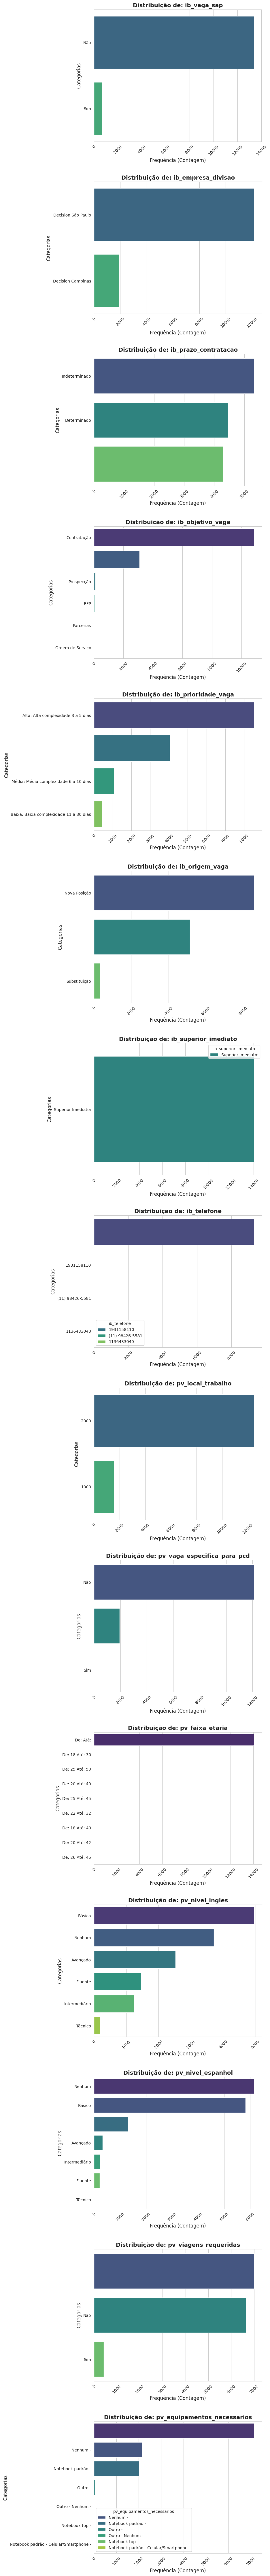

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de estilo para os gráficos
sns.set_style("whitegrid")
sns.set_palette("viridis")

# --- 1. Histograma para Colunas Categóricas (com até 10 valores únicos) ---

# Identificar as colunas a serem plotadas a partir do resumo
categorical_cols_to_plot = (
    jobs_quant_summary
    .filter(
        (pl.col("n_unique") <= 10) &
        (pl.col("n_unique") > 1) 
    )
    .get_column("column")
    .to_list()
)
categorical_cols_to_plot

# Iniciando o plot para colunas categóricas
print(f"--- Plotando a distribuição para {len(categorical_cols_to_plot)} colunas categóricas ---")

# Criar os gráficos
fig, axes = plt.subplots(len(categorical_cols_to_plot), 1, figsize=(10, 6 * len(categorical_cols_to_plot)))

# Se houver apenas uma coluna, axes não será uma lista, então ajustamos
if len(categorical_cols_to_plot) == 1:
    axes = [axes]

for i, col_name in enumerate(categorical_cols_to_plot):
    ax = axes[i]
    # Usando value_counts() para obter a frequência e ordenando
    data_to_plot = jobs_processed.get_column(col_name).value_counts().sort("count", descending=True)

    sns.barplot(
        hue=col_name,
        y=col_name,
        x="count",
        data=data_to_plot,
        ax=ax,
        palette="viridis"
    )
    ax.set_title(f'Distribuição de: {col_name}', fontsize=14, weight='bold')
    ax.set_ylabel('Categorias', fontsize=12)
    ax.set_xlabel('Frequência (Contagem)', fontsize=12)
    ax.tick_params(axis='x', rotation=45, labelsize=10) # Rotaciona os labels para melhor leitura

plt.tight_layout(pad=3.0)
plt.show()

['ib_requisitante', 'ib_analista_responsavel', 'ib_tipo_contratacao', 'pv_estado', 'pv_regiao', 'pv_horario_trabalho', 'pv_nivel profissional', 'pv_nivel_academico', 'pv_outro_idioma', 'pv_areas_atuacao', 'b_valor_compra_2']
--- Plotando a distribuição para 11 colunas categóricas ---


/tmp/ipykernel_19442/4125135564.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=3.0)


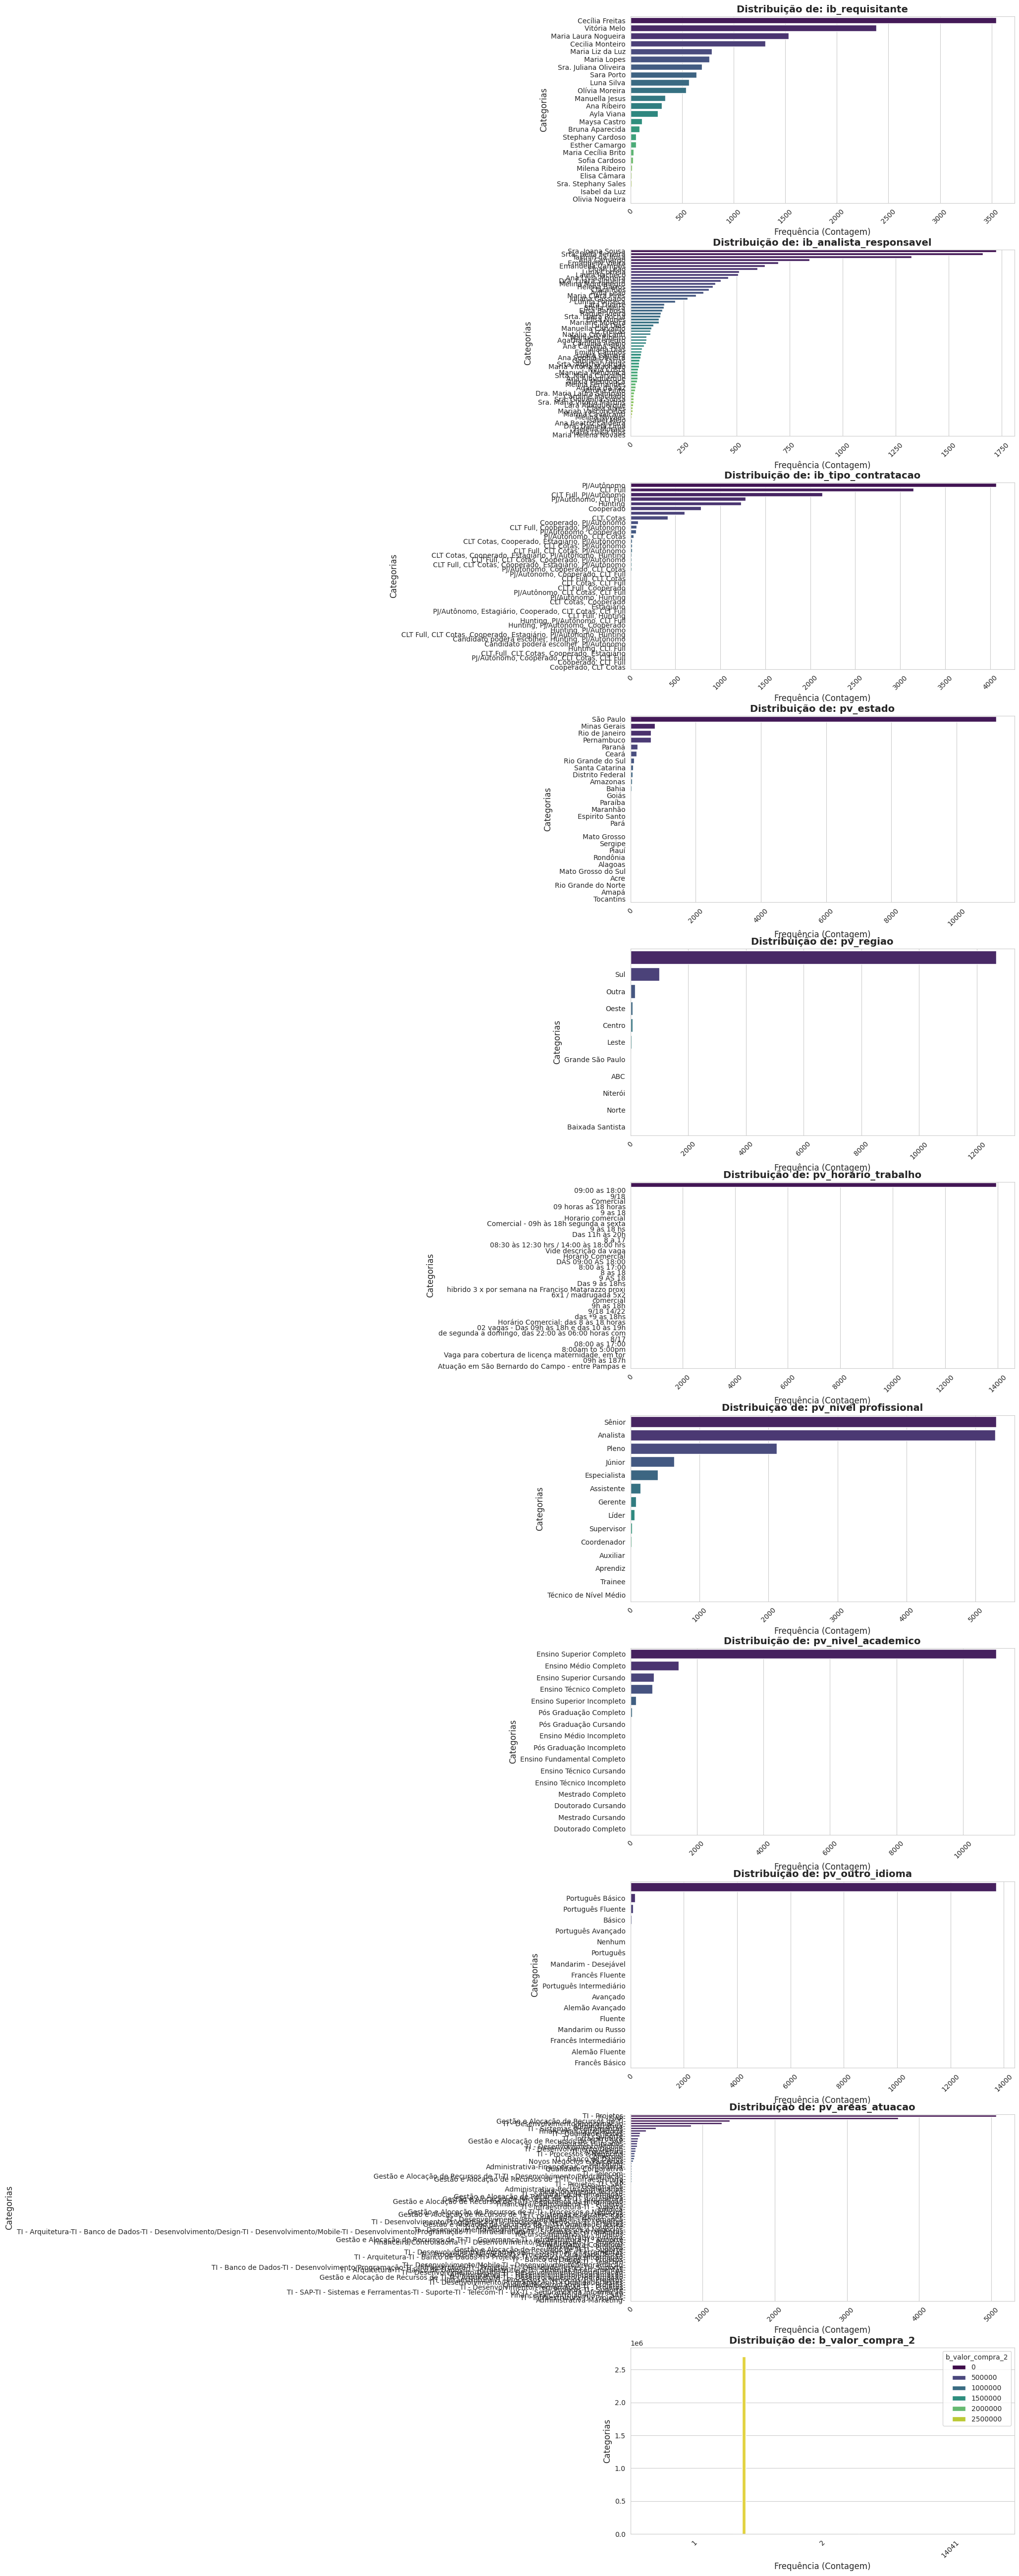

In [10]:
# Identificar as colunas a serem plotadas a partir do resumo
categorical_cols_to_plot = (
    jobs_quant_summary
    .filter(
        (pl.col("n_unique") > 10) &
        (pl.col("n_unique") <= 75) &
        (pl.col("n_unique") > 1) 
    )
    .get_column("column")
    .to_list()
)
print(categorical_cols_to_plot)

# Iniciando o plot para colunas categóricas
print(f"--- Plotando a distribuição para {len(categorical_cols_to_plot)} colunas categóricas ---")

# Criar os gráficos
fig, axes = plt.subplots(len(categorical_cols_to_plot), 1, figsize=(10, 6 * len(categorical_cols_to_plot)))

# Se houver apenas uma coluna, axes não será uma lista, então ajustamos
if len(categorical_cols_to_plot) == 1:
    axes = [axes]

for i, col_name in enumerate(categorical_cols_to_plot):
    ax = axes[i]
    # Usando value_counts() para obter a frequência e ordenando
    data_to_plot = jobs_processed.get_column(col_name).value_counts().sort("count", descending=True)

    sns.barplot(
        hue=col_name,
        y=col_name,
        x="count",
        data=data_to_plot,
        ax=ax,
        palette="viridis"
    )
    ax.set_title(f'Distribuição de: {col_name}', fontsize=14, weight='bold')
    ax.set_ylabel('Categorias', fontsize=12)
    ax.set_xlabel('Frequência (Contagem)', fontsize=12)
    ax.tick_params(axis='x', rotation=45, labelsize=10) # Rotaciona os labels para melhor leitura

plt.tight_layout(pad=3.0)
plt.subplots_adjust(hspace=0.25) 
plt.show()


--- Plotando a distribuição para 3 colunas numéricas ---
[NOTA] Valores extremos (outliers) foram removidos para melhor visualização da distribuição principal.


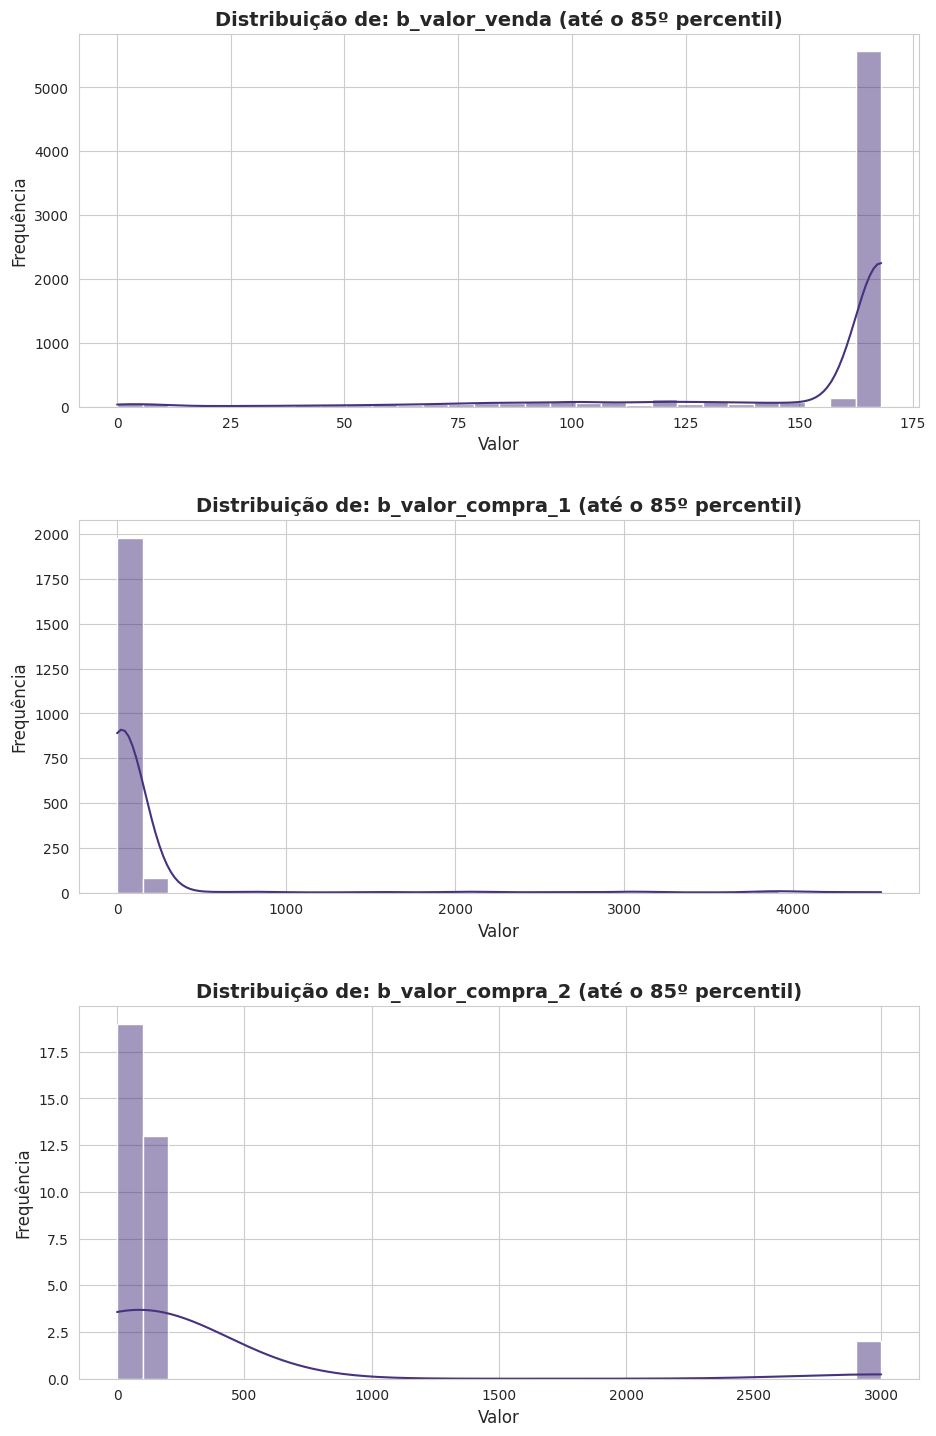

In [11]:
# --- 2. Histograma para Colunas Numéricas (Valores) ---

numerical_cols_to_plot = ["b_valor_venda", "b_valor_compra_1", "b_valor_compra_2"]

print(f"\n--- Plotando a distribuição para {len(numerical_cols_to_plot)} colunas numéricas ---")
print("[NOTA] Valores extremos (outliers) foram removidos para melhor visualização da distribuição principal.")

# Criar os gráficos
fig, axes = plt.subplots(len(numerical_cols_to_plot), 1, figsize=(10, 5 * len(numerical_cols_to_plot)))
if len(numerical_cols_to_plot) == 1:
    axes = [axes]

for i, col_name in enumerate(numerical_cols_to_plot):
    ax = axes[i]
    # Remove nulos e outliers para uma visualização mais clara da distribuição principal
    # Usamos o percentil 99 como limite superior para evitar que outliers extremos achem o gráfico
    
    col_data = jobs_processed.get_column(col_name).drop_nulls()
    # Apenas plota se houver dados na coluna
    if len(col_data) > 0:
        q99 = col_data.quantile(0.85)
        
        sns.histplot(
            data=col_data.filter(col_data <= q99),
            ax=ax,
            kde=True, # Adiciona uma linha de densidade
            bins=30
        )
        ax.set_title(f'Distribuição de: {col_name} (até o 85º percentil)', fontsize=14, weight='bold')
        ax.set_xlabel('Valor', fontsize=12)
        ax.set_ylabel('Frequência', fontsize=12)

plt.tight_layout(pad=3.0)
plt.show()

### Analise final Jobs

A análise dos dados de vagas revelou características relevantes que orientam tanto o tratamento quanto a utilização futura das variáveis. As variáveis foram agrupadas conforme sua natureza (categóricas, numéricas, temporais e qualitativas), e cada uma foi avaliada quanto à sua completude, variabilidade, utilidade analítica e impacto esperado.

#### Variáveis Categóricas

##### 1. `pv_equipamentos_necessarios`
- **Observações**: Alto número de valores nulos. Ainda assim, algumas categorias como "notebook-padrao" e "nenhum" aparecem com frequência.
- **Tratamento sugerido**: Imputar nulos como "Não informado". Usar as categorias mais comuns como variável categórica consolidada.

##### 2. `ib_vaga_sap`
- **Observações**: Distribuição altamente desbalanceada (maioria "Sim"), sem nulos.
- **Tratamento sugerido**: Pode ser mantida como variável binária. O desbalanceamento deve ser considerado no balanceamento dos dados para modelos supervisionados.

##### 3. `ib_empresa_divisao`
- **Observações**: Principais valores concentrados em "São Paulo" e "Campinas". Sem nulos.
- **Tratamento sugerido**: Útil para feature de localização. Pode ser cruzada com local de residência do candidato.

##### 4. `ib_prazo_contratacao`
- **Observações**: Nulos em volume considerável. Três categorias principais bem distribuídas.
- **Tratamento sugerido**: Imputar nulos como "Não informado". Campo relevante para SLA de contratação.

##### 5. `ib_objetivo_vaga`
- **Observações**: Grande parte como "contratação", e outra parte como nulo (não informado). Outras categorias são outliers.
- **Tratamento sugerido**: Reclassificar como binária: “Contratação” vs. “Outros/Não informado”.

##### 6. `ib_prioridade_vaga`
- **Observações**: Boa distribuição. Nulos interpretáveis como “Não informado”.
- **Tratamento sugerido**: Pode ser mantida como ordinal. Avaliar encoding conforme a hierarquia de prioridade.

##### 7. `ib_origem_vaga`
- **Observações**: "Nova posição" e "Não informado" têm altos volumes. "Substituição" também é expressiva.
- **Tratamento sugerido**: Relevante para o entendimento do contexto da vaga. Usar as três principais categorias.

##### 8. `ib_superior_imediato`
- **Observações**: Campo com valor único.
- **Tratamento sugerido**: Deve ser descartado. Não agrega variabilidade.

##### 9. `ib_telefone`
- **Observações**: Dado identificador e não analítico.
- **Tratamento sugerido**: Descartar para fins analíticos.

##### 10. `pv_local_trabalho`
- **Observações**: Campo codificado, sem clareza sem dicionário.
- **Tratamento sugerido**: Descartar, a não ser que seja decodificado e integrado com localidade do candidato.

##### 11. `pv_vaga_especifica_para_pcd`
- **Observações**: Volume de "Sim" extremamente baixo. Praticamente um outlier.
- **Tratamento sugerido**: Descartar do modelo, pois pode introduzir viés sem representar a população.

##### 12. `pv_faixa_etaria`
- **Observações**: Concentração em uma única categoria. Potencial risco de viés e discriminação.
- **Tratamento sugerido**: Descartar por razões éticas e legais.

##### 13. `pv_nivel_de_ingles`
- **Observações**: Distribuição balanceada, categorias bem definidas.
- **Tratamento sugerido**: Usar como variável ordinal.

##### 14. `pv_nivel_de_espanhol`
- **Observações**: Sem outliers, categorias definidas. Nulos representam "Não informado".
- **Tratamento sugerido**: Imputar nulos como "Não informado". Variável útil, mas com menor impacto.

##### 15. `pv_viagens_requeridas`
- **Observações**: Predomínio de "Não" e "Não informado", poucos casos "Sim".
- **Tratamento sugerido**: Pode ser mantida como binária, com atenção ao baixo volume de "Sim".

##### 16. `ib_requisitante`
- **Observações**: Alguns outliers, mas boa distribuição.
- **Tratamento sugerido**: Avaliar com encoding adequado ou anonimizar e agrupar por áreas/departamentos.

##### 17. `ib_analista_responsavel`
- **Observações**: Similar ao anterior. Presença de outliers.
- **Tratamento sugerido**: Seguir a mesma lógica do requisitante.

##### 18. `ib_tipo_contratacao`
- **Observações**: Parece ser multivalorado.
- **Tratamento sugerido**: Aplicar técnica de feature engineering (tokenização e binarização por tipo).

##### 19. `pv_estado`
- **Observações**: Campo com granularidade ampla. Desbalanceado.
- **Tratamento sugerido**: Descartar. Redundante frente a `ib_empresa_divisao`.

##### 20. `pv_regiao`
- **Observações**: Similar ao anterior.
- **Tratamento sugerido**: Descartar.

##### 21. `pv_horario_trabalho`
- **Observações**: Informações operacionais, pouco úteis para predição.
- **Tratamento sugerido**: Descartar.

##### 22. `pv_nivel_profissional`
- **Observações**: Distribuição razoável, com alguns outliers.
- **Tratamento sugerido**: Manter como variável categórica.

##### 23. `pv_nivel_academico`
- **Observações**: Distribuição semelhante ao nível profissional.
- **Tratamento sugerido**: Manter. Pode ter correlação com senioridade.

##### 24. `pv_outro_idioma`
- **Observações**: Campo marginal.
- **Tratamento sugerido**: Descartar, principalmente se forem poucas observações.

##### 25. `pv_areas_atuacao`
- **Observações**: Multivalorado.
- **Tratamento sugerido**: Aplicar feature engineering (binarização por área).

---

#### Variáveis Numéricas

##### 1. `b_valor_venda`, `b_valor_compra_1`, `b_valor_compra_2`
- **Observações**: Alta presença de valores nulos e outliers.
- **Tratamento sugerido**: Avaliar possível transformação logarítmica ou imputação com agrupamentos. Se não houver uso analítico direto, considerar descartá-los.

---

#### Variáveis Temporais

##### 1. `ib_limite_esperado_para_contratacao`
- **Observações**: Informação estratégica para prever urgência.
- **Tratamento sugerido**: Manter. Imputar nulos ou tratá-los como “não especificado”.

##### 2. `ib_data_inicial`
- **Observações**: Marca o início do processo.
- **Tratamento sugerido**: Manter. Pode ser cruzado com a data atual para medir tempo de vaga aberta.

##### 3. `ib_data_final`
- **Observações**: Marca o encerramento do processo.
- **Tratamento sugerido**: Importante para análises históricas e predição de ciclo de vida da vaga.

---

#### Variáveis Qualitativas (Texto Livre)

##### 1. `pv_principais_atividades`
##### 2. `pv_competencia_tecnicas_e_comportamentais`
##### 3. `pv_demais_observacoes`
##### 4. `pv_habilidades_comportamentais_necessarias`
- **Observações**: Campos descritivos em linguagem natural.
- **Tratamento sugerido**: Recomendável aplicar NLP (TF-IDF, Word Embeddings ou LLMs) se houver interesse em modelos baseados em conteúdo ou clustering semântico.

---

#### Considerações sobre Localidade

As variáveis relacionadas à **localização geográfica** da vaga, embora desbalanceadas (concentradas em poucas cidades), podem ser úteis em etapas de **engenharia de atributos** para cruzamento com a residência do candidato, permitindo avaliar proximidade e mobilidade. Serão descartadas como preditoras diretas, mas servirão de base para construção de variáveis derivadas.

---

### Encerramento

Esta análise exploratória fornece uma base sólida para decisões técnicas em preparação de dados, engenharia de atributos e modelagem. As variáveis foram classificadas com base em relevância estatística, completude e valor semântico. O próximo passo envolve a aplicação de transformações, normalizações e vetorização, seguido por testes com algoritmos preditivos e validação cruzada para avaliar o poder explicativo de cada variável no contexto de recomendação de candidatos ou predição de sucesso de vaga.



## Prospect quantitative Analysis

In [12]:
preprocess_prospects = (
    prospects_flat.with_columns(
        pl.col("pr_data_candidatura", "pr_ultima_atualizacao")
        .str.to_date("%d-%m-%Y", strict=False)
    )
)

display(preprocess_prospects.head())

codigo_vaga,titulo,modalidade,pr_nome,pr_codigo_candidato,pr_situacao_candidado,pr_data_candidatura,pr_ultima_atualizacao,pr_comentario,pr_recrutador
str,str,str,str,str,str,date,date,str,str
"""4530""","""CONSULTOR CONTROL M""","""""","""José Vieira""","""25632""","""Encaminhado ao Requisitante""",2021-03-25,2021-03-25,"""Encaminhado para - PJ R$ 72,00/hora""","""Ana Lívia Moreira"""
"""4530""","""CONSULTOR CONTROL M""","""""","""Srta. Isabela Cavalcante""","""25529""","""Encaminhado ao Requisitante""",2021-03-22,2021-03-23,"""encaminhado para - R$ 6.000,00 – CLT Full , não tem empresa aberta""","""Ana Lívia Moreira"""
"""4531""","""2021-2607395-PeopleSoft Application Engine-Domain Consultant""","""""","""Sra. Yasmin Fernandes""","""25364""","""Contratado pela Decision""",2021-03-17,2021-04-12,"""Data de Inicio: 12/04/2021""","""Juliana Cassiano"""
"""4531""","""2021-2607395-PeopleSoft Application Engine-Domain Consultant""","""""","""Alexia Barbosa""","""25360""","""Encaminhado ao Requisitante""",2021-03-17,2021-03-17,"""""","""Juliana Cassiano"""
"""4532""","""""","""""",null,null,null,null,null,null,null


In [13]:
# Gerar e exibir o resumo quantitativo
print("--- Resumo Quantitativo do DataFrame 'jobs_processed' ---")
preprocess_quant_summary = quantitative_analysis(preprocess_prospects)
display(preprocess_quant_summary)

--- Resumo Quantitativo do DataFrame 'jobs_processed' ---


/tmp/ipykernel_19442/4213856035.py:36: DeprecationWarning: `NUMERIC_DTYPES` was deprecated in version 1.0.0. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  if col.dtype in pl.NUMERIC_DTYPES and null_count < len(df):


column,dtype,null_count,null_percent,n_unique,mean,std,min,q25,median,q75,max,iqr,skewness,outlier_count
str,object,i64,f64,i64,null,null,null,null,null,null,null,null,null,null
"""codigo_vaga""",String,0,0.0,14222,null,null,null,null,null,null,null,null,null,null
"""titulo""",String,0,0.0,9911,null,null,null,null,null,null,null,null,null,null
"""modalidade""",String,0,0.0,6,null,null,null,null,null,null,null,null,null,null
"""pr_nome""",String,2943,5.190293,26248,null,null,null,null,null,null,null,null,null,null
"""pr_codigo_candidato""",String,2943,5.190293,29406,null,null,null,null,null,null,null,null,null,null
"""pr_situacao_candidado""",String,2943,5.190293,22,null,null,null,null,null,null,null,null,null,null
"""pr_data_candidatura""",Date,2943,5.190293,1794,null,null,null,null,null,null,null,null,null,null
"""pr_ultima_atualizacao""",Date,6856,12.091284,1584,null,null,null,null,null,null,null,null,null,null
"""pr_comentario""",String,2943,5.190293,12195,null,null,null,null,null,null,null,null,null,null


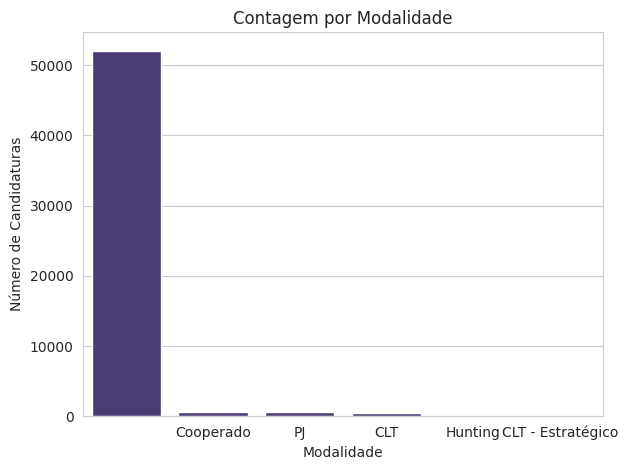

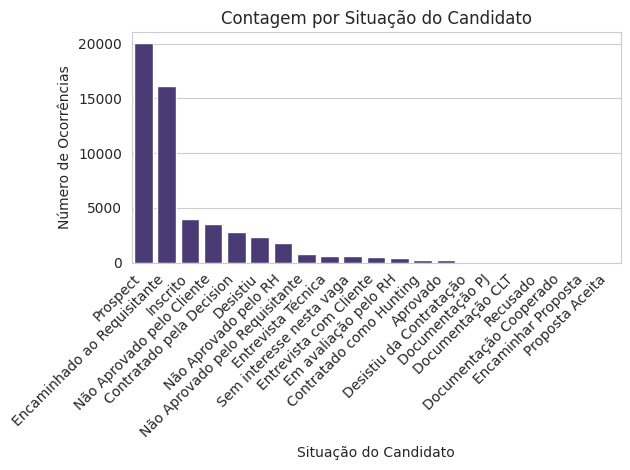

In [14]:
mod_counts = (
    preprocess_prospects
    .filter(
        pl.col("pr_nome").is_not_null()
    )
    .group_by("modalidade")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
)
mod_pd = mod_counts.to_pandas()

plt.figure()
sns.barplot(data=mod_pd, x="modalidade", y="count")
plt.title("Contagem por Modalidade")
plt.xlabel("Modalidade")
plt.ylabel("Número de Candidaturas")
plt.tight_layout()
plt.show()

# 2) Contagem por situação do candidato
situ_counts = (
    preprocess_prospects
    .filter(
        pl.col("pr_nome").is_not_null()
    )
    .group_by("pr_situacao_candidado")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
)
situ_pd = situ_counts.to_pandas()

plt.figure()
sns.barplot(data=situ_pd, x="pr_situacao_candidado", y="count")
plt.title("Contagem por Situação do Candidato")
plt.xlabel("Situação do Candidato")
plt.ylabel("Número de Ocorrências")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Feature Engineering & Enriquecimento via NLP

- **Sumário Quantitativo Rápido**  
  - 14 222 vagas distintas (`codigo_vaga`), 29 406 candidatos (`pr_codigo_candidato`).  
  - ~5,19 % de nulos nas colunas de candidatura (`pr_*`), com destaque para `pr_ultima_atualizacao` (~12,09 %).  
  - 22 situações distintas em `pr_situacao_candidado`, com distribuição equilibrada.  
  - A variável `modalidade` apresenta forte presença de **valores vazios** e **outliers**, o que compromete sua utilidade analítica — **recomenda-se desconsiderá-la como feature preditiva sem prévia limpeza.**

---

### Propostas de Feature Engineering  

1. **Variável-alvo binária (`foi_contratado`)**  
   - Derivar uma coluna target a partir de `pr_situacao_candidado` com 1 para situações que representem contratação e 0 para os demais.

2. **Features Temporais**  
   - `dias_no_processo`: diferença (em dias) entre `pr_data_candidatura` e `pr_ultima_atualizacao`.  
   - `nao_validado`: flag booleana que indica ausência de `pr_data_candidatura`.

3. **Interações e Engajamento**  
   - `interacoes`: número de interações observadas por candidato (pode ser inferido por quantidade de comentários).  
   - `comentarios_validos`: flag indicando se há presença de texto em `pr_comentario`.

4. **Qualidade e Volume de Dados por Recrutador**  
   - `recrutador_top`: classificar `pr_recrutador` com base em volume de candidaturas ou taxa de sucesso.  
   - Devido à alta cardinalidade, essa variável pode ser agrupada em percentis ou reduzida com hashing/embedding.

5. **Tratamento de Categóricas**  
   - **`modalidade` não será considerada devido à predominância de vazios e outliers**.  
   - `titulo`: agrupar via palavras-chave em níveis de senioridade (ex.: “júnior”, “sênior”, “pleno”) ou clusterizar via embeddings semânticos.

---

### Enriquecimento com NLP em `pr_comentario`  

1. **Análise de Sentimento**  
   - Aplicar análise de polaridade (positivo, negativo, neutro) → gerar coluna `sentimento`.

2. **Extração de Palavras-chave**  
   - Usar TF-IDF ou algoritmos como RAKE ou KeyBERT para capturar os termos mais representativos. Criar `keywords_top3`.

3. **Métricas de Estrutura Textual**  
   - `len_comentario`: número de caracteres ou palavras.  
   - `qtd_frases`: número de frases identificadas.  
   - `tem_comentario`: flag booleana se há ou não comentário.

4. **Embeddings de Texto**  
   - Usar modelos como BERT, Sentence-BERT ou DistilBERT para gerar vetores semânticos de `pr_comentario`.  
   - Agregar esses embeddings por `codigo_vaga` ou `pr_codigo_candidato`.

---

### Considerações Finais  

- **`modalidade` deve ser desconsiderada**, a menos que haja uma limpeza rigorosa.  
- `pr_situacao_candidado` apresenta distribuição aceitável e pode servir como base para variável-alvo e avaliação da performance dos recrutadores.  
- As transformações propostas cobrem aspectos temporais, textuais e comportamentais.  
- Após criação das features:
  - Avaliar importância via modelos como Random Forest, LASSO ou SHAP.  
  - Implementar pipeline robusto com sklearn, PySpark ou Airflow para escalar o processo.  
  - Manter atenção à integridade de dados ausentes e coerência semântica das variáveis derivadas.


---

## Applicants analysys final


In [15]:
applicants_prospects = (
    applicants_flat.with_columns(
        pl.col("ib_data_atualizacao")
        .str.strptime(pl.Datetime, "%d-%m-%Y %H:%M:%S", strict=False)
    ).with_columns(
        pl.col("ib_data_criacao")
        .str.strptime(pl.Datetime, "%d-%m-%Y %H:%M:%S", strict=False)
    )
)

display(applicants_prospects.head())

# Gerar e exibir o resumo quantitativo
print("--- Resumo Quantitativo do DataFrame 'applicants_processed' ---")
applicants_quant_summary = quantitative_analysis(applicants_prospects)
display(applicants_quant_summary)

codigo_candidato,ib_telefone_recado,ib_telefone,ib_objetivo_profissional,ib_data_criacao,ib_inserido_por,ib_email,ib_local,ib_sabendo_de_nos_por,ib_data_atualizacao,ib_codigo_profissional,ib_nome,ip_data_aceite,ip_download_cv,ip_nome,ip_cpf,ip_fonte_indicacao,ip_email,ip_email_secundario,ip_data_nascimento,ip_telefone_celular,ip_telefone_recado,ip_sexo,ip_estado_civil,ip_pcd,ip_endereco,ip_skype,ip_url_linkedin,ip_facebook,ip_titulo_profissional,ip_area_atuacao,ip_conhecimentos_tecnicos,ip_certificacoes,ip_outras_certificacoes,ip_remuneracao,ip_nivel_profissional,fei_nivel_academico,fei_instituicao_ensino_superior,fei_cursos,fei_ano_conclusao,fei_nivel_ingles,fei_nivel_espanhol,fei_outro_idioma,cv_pt,cv_en
str,str,str,str,datetime[μs],str,str,str,str,datetime[μs],str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""31000""","""""","""(11) 97048-2708""","""""",2021-11-10 07:29:49,"""Luna Correia""","""carolina_aparecida@gmail.com""","""""","""""",2021-11-10 07:29:49,"""31000""","""Carolina Aparecida""","""Cadastro anterior ao registro de aceite""",null,"""Carolina Aparecida""","""""",""":""","""carolina_aparecida@gmail.com""","""""","""0000-00-00""","""(11) 97048-2708""","""""","""""","""""","""""","""""","""""","""""","""""","""""","""""","""""","""""","""""","""""","""""","""""",null,null,null,"""""","""""","""-""","""assistente administrativo santosbatista itapecerica da serra/sp 29 anos ▪ brasileiro ▪ casado formação acadêmica  bacharel - ciências contábeis centro universitário ítalo brasileiro jul/2015 - dez/…",""""""
"""31001""","""""","""(11) 93723-4396""","""Analista Administrativo""",2021-11-10 08:56:16,"""Laura Pacheco""","""eduardo_rios@hotmail.com""","""São Paulo, São Paulo""","""Outros""",2021-11-11 11:10:31,"""31001""","""Eduardo Rios""","""Cadastro anterior ao registro de aceite""",null,"""Eduardo Rios""","""""","""Outros: Contato do RH""","""eduardo_rios@hotmail.com""","""""","""28-12-1994""","""(11) 93723-4396""","""""","""Feminino""","""Solteiro""","""Não""","""são paulo""","""""","""""","""""","""Analista Administrativo""","""Administrativa""","""""","""""","""""","""1900""","""""","""Ensino Superior Incompleto""",null,null,null,"""Nenhum""","""Nenhum""","""-""","""formação acadêmica ensino médio (2º grau) em ensino médio (2º grau), beatriz lopes em sp jan. 2010 até dez. 2012 ensino superior em administração de empresas, unip em sp jun. 2016 - trancado experiênc…",""""""
"""31002""","""""","""(11) 92399-9824""","""Administrativo | Financeiro""",2021-11-10 09:01:00,"""Laura Pacheco""","""pedro_henrique_carvalho@gmail.com""","""São Paulo, São Paulo""","""Anúncio""",2021-11-10 11:42:36,"""31002""","""Pedro Henrique Carvalho""","""Cadastro anterior ao registro de aceite""",null,"""Pedro Henrique Carvalho""","""""","""Anúncio:""","""pedro_henrique_carvalho@gmail.com""","""""","""12-12-1988""","""(11) 92399-9824""","""""","""Feminino""","""Solteiro""","""Não""","""são paulo""","""""","""""","""""","""Administrativo | Financeiro""","""Administrativa""","""""","""MS [77-418] MOS: Microsoft Office Word 2013, MS [77-420] MOS: Microsoft Office Excel 2013, MS [77-423] MOS: Microsoft Office Outlook 2013, MS [77-422] MOS: Microsoft Office PowerPoint 2013, SAP FI""","""""","""2.500,00""","""""","""Ensino Superior Completo""","""""","""Administração de Empresas""","""2012""","""Intermediário""","""Básico""","""Português - Fluente""","""objetivo: área administrativa | financeira resumo profissional graduada em administração de empresas e cursando tecnologia em gestão da cadeia de suprimentos e logística. profissional com mais de 11…",""""""
"""31003""","""""","""(11) 98100-1727""","""Área administrativa""",2021-11-10 09:08:13,"""Laura Pacheco""","""thiago_barbosa@hotmail.com""","""São Paulo, São Paulo""","""Site de Empregos""",2021-11-10 16:04:51,"""31003""","""Thiago Barbosa""","""Cadastro anterior ao registro de aceite""",null,"""Thia

--- Resumo Quantitativo do DataFrame 'applicants_processed' ---


/tmp/ipykernel_19442/4213856035.py:36: DeprecationWarning: `NUMERIC_DTYPES` was deprecated in version 1.0.0. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  if col.dtype in pl.NUMERIC_DTYPES and null_count < len(df):


column,dtype,null_count,null_percent,n_unique,mean,std,min,q25,median,q75,max,iqr,skewness,outlier_count
str,object,i64,f64,i64,null,null,null,null,null,null,null,null,null,null
"""codigo_candidato""",String,0,0.0,42482,null,null,null,null,null,null,null,null,null,null
"""ib_telefone_recado""",String,0,0.0,1,null,null,null,null,null,null,null,null,null,null
"""ib_telefone""",String,0,0.0,41026,null,null,null,null,null,null,null,null,null,null
"""ib_objetivo_profissional""",String,0,0.0,8368,null,null,null,null,null,null,null,null,null,null
"""ib_data_criacao""","Datetime(time_unit='us', time_zone=None)",19,0.044725,41707,null,null,null,null,null,null,null,null,null,null
"""ib_inserido_por""",String,0,0.0,63,null,null,null,null,null,null,null,null,null,null
"""ib_email""",String,0,0.0,41482,null,null,null,null,null,null,null,null,null,null
"""ib_local""",String,0,0.0,721,null,null,null,null,null,null,null,null,null,null
"""ib_sabendo_de_nos_por""",String,0,0.0,14,null,null,null,null,null,null,null,null,null,null


cv_en nenhum input

fei_ano_conclusao fei_cursos fei_instituicao_ensino_superior ip_download_cv desconsiderar pelo grande numero de nulos

fei_nivel_ingles fei_nivel_espanhol ip_nivel_profissional fei_nivel_academico ip_endereco ip_estado_civil ib_sabendo_de_nos_por - unicos pequenos e quero ver a distribuicao de cada um

ip_remuneracao  ip_conhecimentos_tecnicos  ip_titulo_profissional ip_fonte_indicacao -> classificar entre as 3000 e clusterizar

ip_outras_certificacoes ip_certificacoes ip_area_atuacao -> mais de 200 unicos avaliar cluster

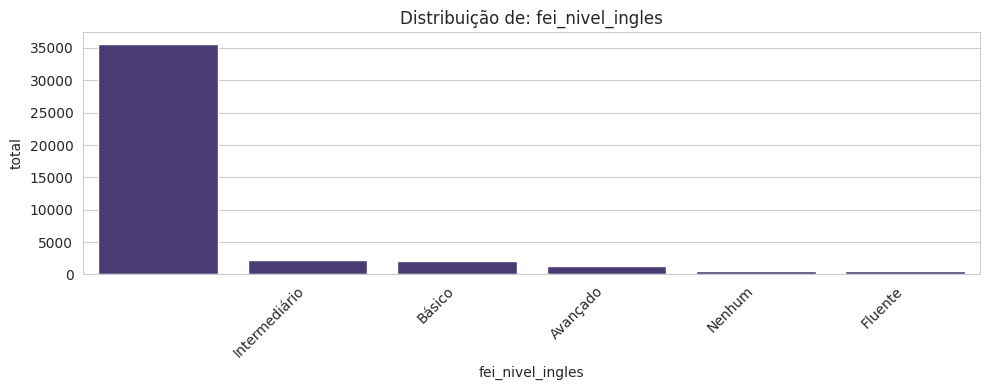

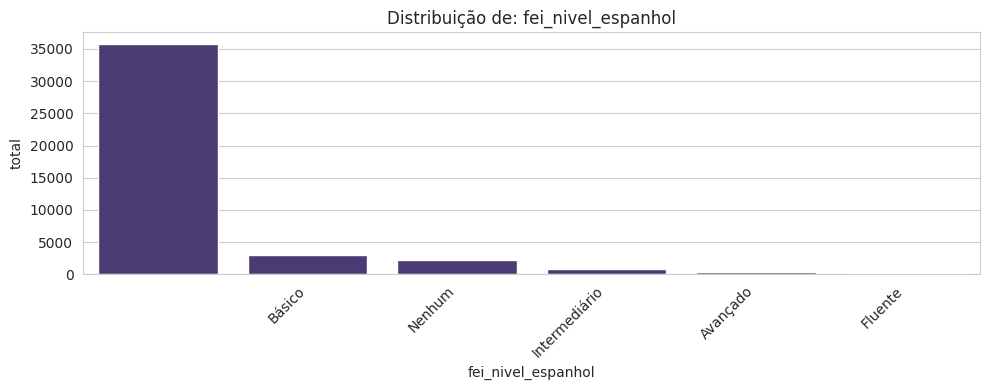

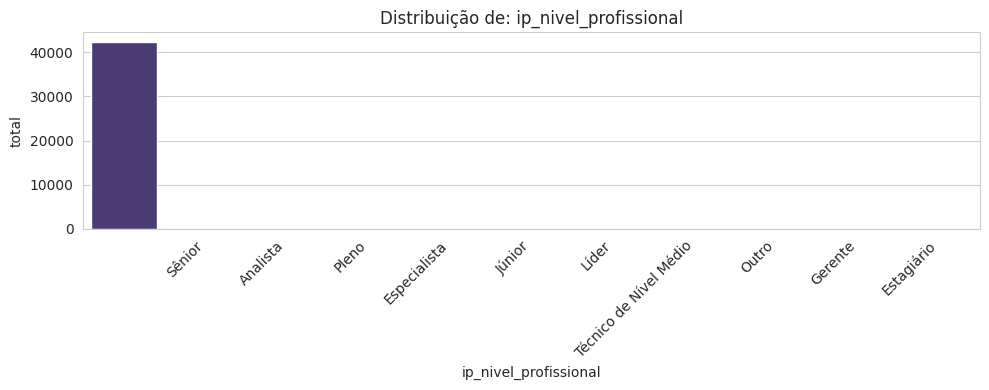

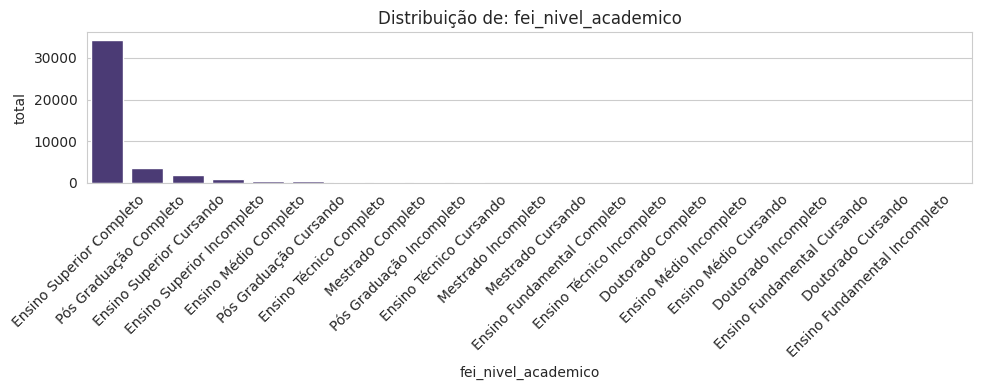

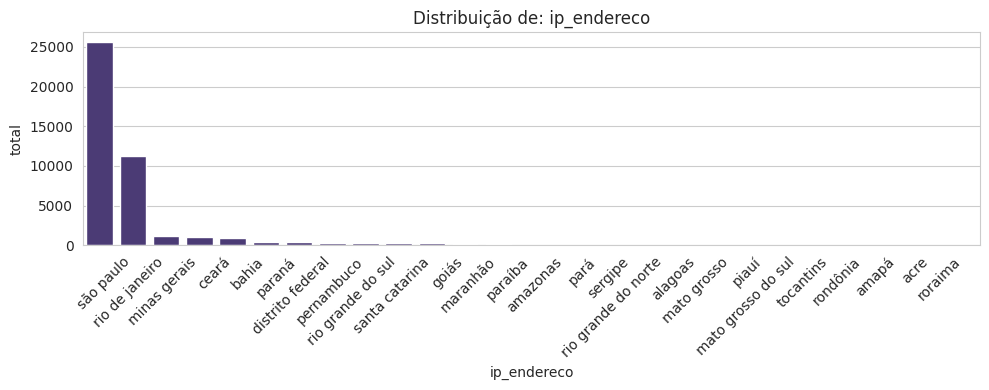

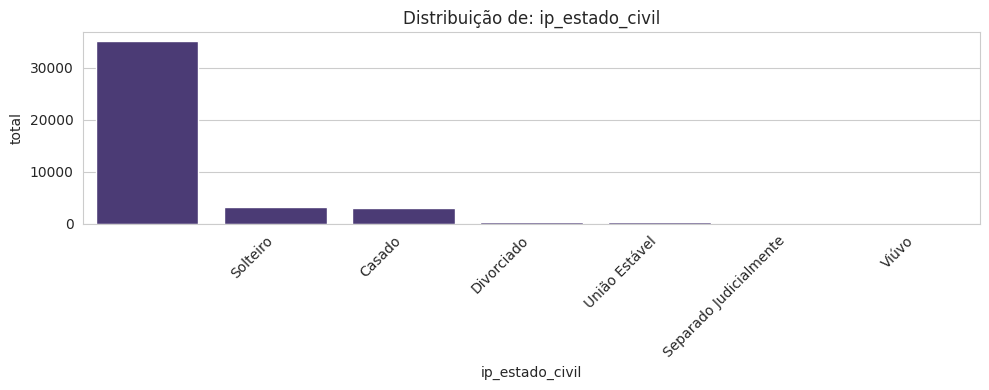

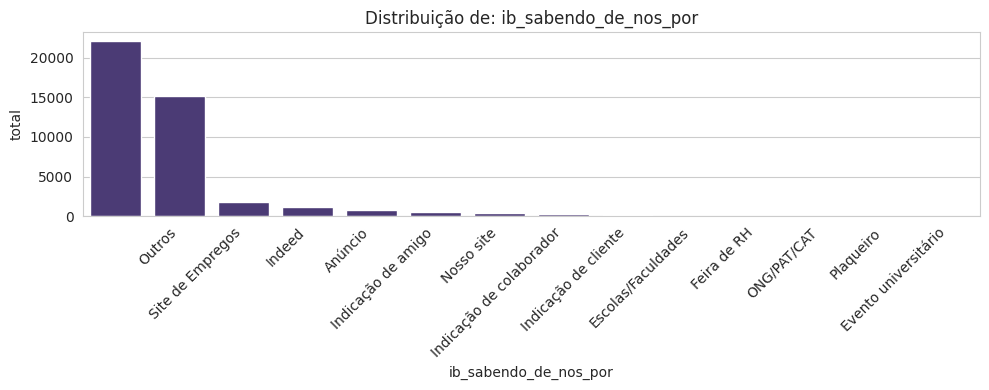

In [16]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de variáveis com poucos valores únicos
categorical_few_uniques = [
    "fei_nivel_ingles",
    "fei_nivel_espanhol",
    "ip_nivel_profissional",
    "fei_nivel_academico",
    "ip_endereco",
    "ip_estado_civil",
    "ib_sabendo_de_nos_por"
]

# Plot para cada variável
for col in categorical_few_uniques:
    counts = applicants_prospects.group_by(col).agg(pl.len().alias("total")).sort("total", descending=True).to_pandas()
    plt.figure(figsize=(10, 4))
    sns.barplot(data=counts, x=col, y="total")
    plt.title(f"Distribuição de: {col}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


In [21]:
applicants_prospects.filter(pl.col("ib_nome")=="")

codigo_candidato,ib_telefone_recado,ib_telefone,ib_objetivo_profissional,ib_data_criacao,ib_inserido_por,ib_email,ib_local,ib_sabendo_de_nos_por,ib_data_atualizacao,ib_codigo_profissional,ib_nome,ip_data_aceite,ip_download_cv,ip_nome,ip_cpf,ip_fonte_indicacao,ip_email,ip_email_secundario,ip_data_nascimento,ip_telefone_celular,ip_telefone_recado,ip_sexo,ip_estado_civil,ip_pcd,ip_endereco,ip_skype,ip_url_linkedin,ip_facebook,ip_titulo_profissional,ip_area_atuacao,ip_conhecimentos_tecnicos,ip_certificacoes,ip_outras_certificacoes,ip_remuneracao,ip_nivel_profissional,fei_nivel_academico,fei_instituicao_ensino_superior,fei_cursos,fei_ano_conclusao,fei_nivel_ingles,fei_nivel_espanhol,fei_outro_idioma,cv_pt,cv_en
str,str,str,str,datetime[μs],str,str,str,str,datetime[μs],str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str


In [ ]:
toatl_count = applicants_prospects.height
print(f"Total de registros: {toatl_count}")

list_values = [] 

for item in applicants_prospects.schema.items():
    if item[1] == pl.String:
        col_name = item[0]
        n_vazia = applicants_prospects.select([col_name]).filter(pl.col(col_name) == '').height
        percentage = (n_vazia / toatl_count) * 100
        if percentage > 20:
            list_values.append((col_name, n_vazia, percentage))

print("Colunas com mais de 20% de valores vazios:")
for col, count, perc in  sorted(list_values, key=lambda x: x[2], reverse=True):
    print(f"{col}: {count} ({perc:.2f}%)")

Total de registros: 42482
Colunas com mais de 20% de valores vazios:
ib_telefone_recado: 42482 (100.00%)
ip_cpf: 42482 (100.00%)
ip_email_secundario: 42482 (100.00%)
ip_telefone_recado: 42482 (100.00%)
ip_skype: 42482 (100.00%)
ip_url_linkedin: 42482 (100.00%)
ip_facebook: 42482 (100.00%)
cv_en: 42482 (100.00%)
ip_nivel_profissional: 42402 (99.81%)
ip_certificacoes: 41954 (98.76%)
ip_outras_certificacoes: 41583 (97.88%)
ip_conhecimentos_tecnicos: 39129 (92.11%)
ip_pcd: 36161 (85.12%)
fei_nivel_espanhol: 35795 (84.26%)
ip_area_atuacao: 35731 (84.11%)
fei_nivel_ingles: 35638 (83.89%)
ip_sexo: 35298 (83.09%)
ip_estado_civil: 35031 (82.46%)
fei_nivel_academico: 34388 (80.95%)
ip_endereco: 25554 (60.15%)
ib_local: 25474 (59.96%)
ip_remuneracao: 22345 (52.60%)
ib_sabendo_de_nos_por: 22106 (52.04%)
ib_objetivo_profissional: 14416 (33.93%)
ip_titulo_profissional: 14416 (33.93%)
cv_pt: 13431 (31.62%)


# Análise de Qualidade de Dados e Ações Recomendadas

Este relatório apresenta uma análise detalhada sobre o schema do dataset, considerando os seguintes aspectos:
- Colunas com valores ausentes
- Cardinalidade
- Distribuição categórica
- Potencial analítico
- Ações sugeridas por grupo de colunas

Total de registros: **42.482**

---

## 1. Colunas com 100% de valores nulos

**Colunas afetadas:**  
`ib_telefone_recado`, `ip_cpf`, `ip_email_secundario`, `ip_telefone_recado`, `ip_skype`, `ip_url_linkedin`, `ip_facebook`, `cv_en`

**Problema:**  
Essas colunas estão completamente vazias, o que sugere:
- Campos obsoletos ou nunca utilizados
- Atributos criados mas não populados
- Dados esperados de fontes externas não integradas

**Ação recomendada:**
- Verificar com stakeholders a relevância futura desses campos
- Remover do dataset atual para reduzir carga técnica
- Marcar como "não utilizados" na documentação técnica

---

## 2. Colunas com entre 80% e 99% de valores nulos

**Colunas afetadas:**  
`ip_nivel_profissional`, `ip_certificacoes`, `ip_outras_certificacoes`, `ip_conhecimentos_tecnicos`, `ip_pcd`,  
`fei_nivel_espanhol`, `ip_area_atuacao`, `fei_nivel_ingles`, `ip_sexo`, `ip_estado_civil`, `fei_nivel_academico`

**Problema:**  
Campos com alta sparsidade que podem ainda conter valor analítico, especialmente em análises segmentadas.

**Ação recomendada:**
- Avaliar importância analítica antes de descartar
- Criar flags de presença (ex: `tem_nivel_ingles`)
- Usar técnicas como imputação estatística ou indicadores de ausência
- Considerar tornar o preenchimento obrigatório em coletas futuras

---

## 3. Colunas com 30% a 60% de valores nulos

**Colunas afetadas:**  
`ip_endereco`, `ib_local`, `ip_remuneracao`, `ib_sabendo_de_nos_por`, `ib_objetivo_profissional`,  
`ip_titulo_profissional`, `cv_pt`

**Problema:**  
Nível de completude intermediário, com volume suficiente para análise, mas com perda de contexto se não tratados.

**Ação recomendada:**
- Avaliar distribuição e relevância estatística dos dados válidos
- Usar preenchimento por similaridade ou categorização auxiliar
- Criar visualizações para análise de distribuição

---

## 4. Colunas com poucos valores únicos (categorias pequenas)

**Colunas afetadas:**  
`fei_nivel_ingles`, `fei_nivel_espanhol`, `ip_nivel_profissional`, `fei_nivel_academico`,  
`ip_endereco`, `ip_estado_civil`, `ib_sabendo_de_nos_por`

**Problema:**  
Baixa cardinalidade, mas potencialmente relevantes para filtros e agrupamentos.

**Ação recomendada:**
- Avaliar a distribuição de cada categoria
- Usar em dashboards, análises de coorte ou segmentações
- Codificar com one-hot ou target encoding conforme necessidade analítica

---

## 5. Colunas de texto livre com alta cardinalidade

**Colunas afetadas:**  
`ip_remuneracao`, `ip_conhecimentos_tecnicos`, `ip_titulo_profissional`, `ip_fonte_indicacao`,  
`ip_outras_certificacoes`, `ip_certificacoes`, `ip_area_atuacao`

**Problema:**  
Campos com dados não normalizados e alta diversidade de valores.

**Ação recomendada:**
- Aplicar limpeza e padronização textual (normalização, remoção de acentos)
- Usar vetorização (TF-IDF) + clustering (KMeans, HDBSCAN, SBERT)
- Reduzir para Top-N categorias mais frequentes + grupo "outros"
- Aplicar categorização manual ou semiautomática com apoio de domínio

---

## 6. Colunas com alta cardinalidade e sem valores nulos

**Colunas afetadas:**  
`ib_nome`, `ip_nome`, `ib_email`, `ip_email`, `ip_cpf`, `ip_telefone_celular`, `ib_codigo_profissional`, `codigo_candidato`

**Problema:**  
Essas colunas representam dados pessoais sensíveis (PII) ou identificadores únicos.

**Ação recomendada:**
- Remover de datasets analíticos
- Aplicar pseudonimização ou hashing seguro
- Usar apenas para identificação, e não em modelos preditivos

---

## 7. Colunas quase constantes

**Colunas afetadas:**  
Exemplos como `ip_skype`, `ip_facebook`, `ip_email_secundario` têm apenas 1 valor distinto.

**Problema:**  
Não oferecem variação e, portanto, não agregam valor informacional.

**Ação recomendada:**
- Remover do pipeline de dados
- Verificar se são campos default ("não informado") e revisar coleta

---

## 8. Campos temporais com nulos pontuais

**Colunas afetadas:**  
`ib_data_criacao`, `ib_data_atualizacao`

**Problema:**  
Baixo percentual de nulos, mas importantes para auditoria e análises temporais.

**Ação recomendada:**
- Preencher valores ausentes com regras de negócio (ex: usar `data_criacao` onde `data_atualizacao` for nula)
- Verificar consistência temporal (ex: criação < atualização)
- Usar para análises de jornada ou cohort

---

## Ações Gerais Recomendadas

| Ação | Descrição |
|------|-----------|
| **Mapeamento de Completude** | Gerar uma matriz de preenchimento e flag de completude por variável. |
| **Padronização de Texto** | Aplicar normalização textual para campos livres com alta cardinalidade. |
| **Criação de Variáveis Derivadas** | Exemplo: `has_certificacao`, `remuneracao_faixa`, `tem_linkedin`. |
| **Documentação de Campos Opcionais** | Listar campos não obrigatórios e sua taxa de preenchimento esperada. |
| **Revisão de Segurança e Privacidade** | Isolar PII, aplicar criptografia/hash conforme política da LGPD. |
| **Dashboard de Qualidade de Dados** | Implementar visualizações para facilitar monitoramento de qualidade. |

---

## Próximos Passos Técnicos (sugestões)

- Cálculo automático da distribuição de valores únicos para variáveis categóricas com baixa cardinalidade
- Agrupamento automático de campos textuais (TF-IDF + KMeans)
- Módulo de pré-processamento com tratamento automatizado de nulos
- Análise de similaridade entre variáveis (`ip_titulo_profissional` e `ib_objetivo_profissional`)
- Separação de tabelas de entidade (dimensões) e fatos (eventos/candidaturas)

---
